# Introduction
Ce notebook comporte l'implémentation sur Python des algorithmes présentés dans l'article *Clustering Time Series using Unsupervised-Shapelets* par Zakaria et al., ainsi que des exemples d'utilisation des algorithmes avec des données synthétiques (générées par nous-mêmes) et des jeux de données utilisés dans l'article.

# 1. Implémentation des algorithmes

In [1]:
# Importation des libraries 
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from itertools import combinations
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches

## 1.1 Algorithmes de détection des U-Shapelets

In [2]:
# Définition des fonctions internes 

def z_norm(s):
    """
    Applique la Z-normalisation à un vecteur ou une série temporelle.
    
    La Z-normalisation transforme les données de sorte que :
    - La moyenne devient 0.
    - L'écart-type devient 1.
    
    Si toutes les valeurs du vecteur sont identiques (écart-type = 0), 
    la fonction retourne un vecteur de zéros pour éviter la division par zéro.

    Args:
        s (array-like): Série temporelle ou vecteur numérique.

    Returns:
        numpy.ndarray: Série normalisée avec moyenne 0 et écart-type 1.

    """
    s = np.asarray(s)
    
    mean = np.mean(s)
    std = np.std(s)

    if std == 0:  # Gérer le cas où toutes les valeurs sont identiques
        return np.zeros_like(s)
    else:
        return (s - mean) / std


def f_euclideanDistance(s, t):
    """
    Cette fonction calcule la distance euclidienne entre deux vecteurs s et t.
    """
    s, t = np.array(s), np.array(t)  # Conversion des entrées en tableaux numpy
    if s.shape != t.shape:
        raise ValueError("Les vecteurs s et t doivent avoir la même forme.")  # Vérification de la compatibilité des dimensions
    return np.sqrt(np.sum((s - t) ** 2))  # Calcul de la distance euclidienne


def find(liste, point, sens): 
    """
    Cette fonction sépare les éléments d'une liste en deux sous-listes, en fonction de leur position par rapport à un point donné.
    'sens' indique si on retourne les valeurs inférieures ('inf') ou supérieures/égales.
    """
    Da, Db = [], []  # Initialisation des listes de stockage
    sorted_list = sorted(liste)  # Tri de la liste sans modifier l'originale
    
    # Séparation des valeurs
    for elem in sorted_list:
        if elem < point:
            Da.append(elem)  # Ajout aux valeurs inférieures
        else:
            Db.append(elem)  # Ajout aux valeurs supérieures ou égales
    
    # Retour du résultat en fonction du sens
    if sens == "inf":
        return np.array(Da)  # Retourne les valeurs inférieures
    else:
        return np.array(Db)  # Retourne les valeurs supérieures ou égales


In [3]:
def computeDistance(shapelet, D):
    """
    Calcule la distance entre une shapelet et chaque série temporelle dans D.

    Args:
    - shapelet : une sous-séquence.
    - D : DataFrame ou matrice contenant des séries temporelles.

    Returns:
    - dis : Liste des distances (une par série temporelle).
    """
    distances = []
    shapelet = z_norm(shapelet)
    subs = []
    for i, row in D.iterrows():  # Pour chaque série dans D
        ts = row.values
        # Distance minimale entre la shapelet et toutes les sous-séquences de la série
        min_distance = float('inf')
        subse = 0
        for j in range(len(ts) - len(shapelet) + 1):
            subsequence = z_norm(ts[j:j + len(shapelet)])
            dist = np.linalg.norm(subsequence-shapelet)
            if dist < min_distance :
                min_distance =  dist
                subse = subsequence
        distances.append(min_distance)
        subs.append(subse)
    return distances/np.sqrt(len(shapelet)),subs

In [4]:
def computeGap(subsequence, D, k):
    """
    Calcul de l'écart (gap) entre les distances des sous-séquences dans D.
    
    Args:
    - subsequence : la sous-séquence pour laquelle l'écart est calculé.
    - D : DataFrame ou matrice contenant les séries temporelles.
    - k : paramètre utilisé pour le calcul de la condition de ratio.
    
    Returns:
    - maxGap : l'écart maximal trouvé.
    - dt : la distance associée à l'écart maximal.
    """
    # Calcul des distances entre la sous-séquence et les données
    dis,sub = computeDistance(subsequence, D)

    # Tri des distances
    dis.sort()
    
    # Initialisation des variables
    maxGap, dt = 0, 0
    gap = 0
    
    # Calcul du gap pour chaque paire de distances successives
    for l in range(len(dis) - 2):
        # Calcul de la distance moyenne entre deux distances successives
        d = (dis[l] + dis[l + 1]) / 2
        
        # Modifier cette partie car la liste est déjà sort
        
        # Recherche des distances inférieures et supérieures à 'd'
        DA = [x for x in dis if x < d]  # distances inférieures à d
        DB = [x for x in dis if x >= d]  # distances supérieures ou égales à d

        # Calcul du ratio entre la taille de DA et DB
        r = len(DA) / len(DB) if len(DB) > 0 else float('inf')

        # Vérification de la condition pour le ratio en fonction de k
        if k == 2:
            # Pour k=2, on impose une tolérance autour de 1 (exemple : 0.8 <= r <= 1.25)
            ratio_tolerance = 0.5  # Tolérance autour de 1
            if 1 - ratio_tolerance <= r <= 1 + ratio_tolerance:
                # Calcul du gap comme différence entre les moyennes et écarts-types
                gap = np.mean(DB) - np.std(DB) - (np.mean(DA) + np.std(DA))

                if gap > maxGap:
                    maxGap = gap
                    dt = d

        else:
            # Condition générale pour k > 2
            if 1 / k <= r <= 1 - 1 / k:
                
                # Calcul du gap comme différence entre les moyennes et écarts-types
                gap = np.mean(DB) - np.std(DB) - (np.mean(DA) + np.std(DA))

                # Mise à jour du maxGap si nécessaire
                if gap > maxGap:
                    maxGap = gap
                    dt = d
    
    return maxGap, dt

In [5]:
def extractUShapelets(D, sLen, k, minLen):
    """
    Extrait des U-shapelets à partir d'un ensemble de séries temporelles.
    
    Args:
    - D : DataFrame ou matrice de séries temporelles (chaque ligne est une série).
    - sLen : la longueur maximale des U-shapelets à extraire.
    - k : un paramètre pour le calcul du gap.
    
    Returns:
    - S : Liste contenant les U-shapelets extraits.
    """
    S = []  # Ensemble des U-shapelets, initialement vide
    
    # Sélectionner la première série temporelle de D
    ts = D.iloc[0, :].values  # La première série temporelle
    D_second = D

    
    serie = []
    while True:
        cnt = 0  # Compteur pour le nombre de U-shapelets candidats
        s = []  # Ensemble de sous-séquences
        gap_list = []  # Liste des scores de gap
        dt_list = []   # Liste des distances
        
        # Générer des sous-séquences de longueurs de 1 à sLen
        for sl in range(minLen, sLen + 1):
            for i in range(len(ts) - sl + 1):
                subsequence = ts[i:i + sl]  # Sous-séquence de longueur sl
                s.append(subsequence.tolist())  # Convertir chaque sous-séquence en liste avant de l'ajouter
                
                # Calculer le gap et la distance pour cette sous-séquence
                gap, dt = computeGap(subsequence, D_second, k)
                gap_list.append(gap)
                dt_list.append(dt)
                cnt += 1

        # Trouver l'indice de la sous-séquence avec le score de gap maximal
        index1 = np.argmax(gap_list)
        S.append(s[index1])  # Ajouter cette sous-séquence à l'ensemble S
        
        best_dt = dt_list[index1] 

        # Calculer les distances de cette sous-séquence par rapport à toutes les séries
        
        dis,sub = computeDistance(s[index1], D)

        serie.append(ts)

        # Trouver les series dont la distance est inférieure à dt
        DA = [d for i, d in enumerate(dis) if d < best_dt]
        disDA = [d for i, d in enumerate(dis) if d < best_dt]
        DB = [i for i, d in enumerate(dis) if d > best_dt]

        # Si un seul point satisfait cette condition, on arrête la boucle
        if len(DA) <= 1:
            break

        # Si plusieurs points satisfont la condition, on choisit une nouvelle série temporelle
        index2 = np.argmax(dis)
        ts = D.iloc[index2, :].values  # Mettre à jour ts avec la nouvelle série temporelle
        
        # Calculer le seuil theta pour éliminer certaines séries
        theta = np.mean(disDA) + np.std(disDA)
        
        # Trouver les séries dont la distance est inférieure à theta
        D_prime = [i for i, d in enumerate(dis) if d < theta]

        # Supprimer les séries de D dont la distance est inférieure à theta
        D = D.drop(D.index[D_prime])

        # Si le dataset devient vide ou contient une seule série, on arrête la boucle
        if D.empty or len(D) == 1:
            break
        
    return S, serie  # Retourner l'ensemble des U-shapelets extraits

### Nouvelles fonctions pour le calcul de distances et du gap 

Dans cette partie, nous apportons des modifications aux algorithmes proposés par les auteurs afin de les rendre moins coûteux computationnellement.

In [6]:
import numpy as np
from numpy.lib.stride_tricks import as_strided

def computeDistance(shapelet, D):

    """
    Calcule la distance entre une shapelet et chaque série temporelle dans D.

    Args:
    - shapelet : une sous-séquence.
    - D : DataFrame ou matrice contenant des séries temporelles.

    Returns:
    - dis : Liste des distances (une par série temporelle).
    """
    
    shapelet = z_norm(shapelet)
    shapelet_len = len(shapelet)
    data = D.to_numpy()
    
    distances = np.full(len(data), np.inf)
    subs = np.empty((len(data), shapelet_len))

    for i, ts in enumerate(data):
        if len(ts) < shapelet_len:
            continue  # Ignorer les séries trop courtes
        
        # Extraction des sous-séquences sans boucle
        shape = (len(ts) - shapelet_len + 1, shapelet_len)
        strides = (ts.strides[0], ts.strides[0])
        subsequences = as_strided(ts, shape=shape, strides=strides)
        
        # Normalisation vectorisée
        mean = subsequences.mean(axis=1, keepdims=True)
        std = subsequences.std(axis=1, keepdims=True)
        std[std == 0] = 1  # Éviter la division par zéro
        subsequences = (subsequences - mean) / std
        
        # Calcul des distances
        dists = np.linalg.norm(subsequences - shapelet, axis=1)
        min_idx = np.argmin(dists)
        distances[i] = dists[min_idx]
        subs[i] = subsequences[min_idx]

    return distances / np.sqrt(shapelet_len), subs


In [7]:
import bisect
import numpy as np

def computeGap(subsequence, D, k):
    """
    Calcul de l'écart (gap) entre les distances des sous-séquences dans D.
    
    Args:
    - subsequence : la sous-séquence pour laquelle l'écart est calculé.
    - D : DataFrame ou matrice contenant les séries temporelles.
    - k : paramètre utilisé pour le calcul de la condition de ratio.
    
    Returns:
    - maxGap : l'écart maximal trouvé.
    - dt : la distance associée à l'écart maximal.
    """
    # Calcul des distances entre la sous-séquence et les données
    dis, _ = computeDistance(subsequence, D)
    
    # Vérification des entrées
    if len(dis) < 2:
        return 0, 0  # Pas assez de points pour calculer un gap
    
    # Tri des distances
    dis = np.sort(dis)
    
    # Calcul des moyennes des paires successives
    d_values = (dis[:-1] + dis[1:]) / 2  

    # Calcul des tailles de DA et DB en une seule opération
    DA_sizes = np.searchsorted(dis, d_values, side='left')
    DB_sizes = len(dis) - DA_sizes

    # Filtrage des valeurs valides
    valid_indices = (DA_sizes > 0) & (DB_sizes > 0)
    DA_sizes, DB_sizes, d_values = DA_sizes[valid_indices], DB_sizes[valid_indices], d_values[valid_indices]

    # Calcul des ratios
    ratios = DA_sizes / DB_sizes

    # Calcul des gaps
    gaps = np.zeros_like(d_values)
    for i, DA_size in enumerate(DA_sizes):
        DA, DB = dis[:DA_size], dis[DA_size:]
        gaps[i] = np.mean(DB) - np.std(DB) - (np.mean(DA) + np.std(DA))

    # Filtrage des ratios selon k
    if k == 2:
        ratio_tolerance = 0.2
        valid_ratio_indices = (1 - ratio_tolerance <= ratios) & (ratios <= 1 + ratio_tolerance)
    else:
        valid_ratio_indices = (1 / k <= ratios) & (ratios <= 1 - 1 / k)

    # Sélection du meilleur gap
    if np.any(valid_ratio_indices):
        max_idx = np.argmax(gaps[valid_ratio_indices])
        return gaps[valid_ratio_indices][max_idx], d_values[valid_ratio_indices][max_idx]

    return 0, 0


In [8]:
import numpy as np
import pandas as pd
from numpy.lib import stride_tricks

def extractUShapelets(D, sLen, k, minLen):
    """
    Extrait des U-shapelets à partir d'un ensemble de séries temporelles.

    Args:
    - D : DataFrame ou matrice de séries temporelles (chaque ligne est une série).
    - sLen : la longueur maximale des U-shapelets à extraire.
    - k : un paramètre pour le calcul du gap.
    - minLen : longueur minimale des U-shapelets.

    Returns:
    - S : Liste contenant les U-shapelets extraits.
    - serie : Liste des sous-séquences associées.
    """
    S = []  # Liste des U-shapelets extraits
    serie = []  # Liste des sous-séquences associées

    active_indices = np.arange(len(D))  # Liste des indices encore actifs
    ts = D.iloc[active_indices[0], :].values  # Première série temporelle
    #D_second = D.copy()

    while len(active_indices) > 1:
        cnt = 0  
        s = []  # Liste des sous-séquences
        gap_list = []  # Scores de gap
        dt_list = []   # Distances associées
        
        # Générer des sous-séquences avec stride_tricks pour éviter les copies
        for sl in range(minLen, sLen + 1):
            shape = (len(ts) - sl + 1, sl)
            strides = (ts.strides[0], ts.strides[0])
            subsequences = stride_tricks.as_strided(ts, shape=shape, strides=strides)

            for subsequence in subsequences:
                s.append(subsequence.tolist())  
                gap, dt = computeGap(subsequence, D, k)  # Calcul du gap et de la distance
                gap_list.append(gap)
                dt_list.append(dt)
                cnt += 1

        # Trouver la sous-séquence avec le meilleur score de gap
        index1 = np.argmax(gap_list)
        S.append(s[index1])  

        best_dt = dt_list[index1]  
        dis, sub = computeDistance(s[index1], D.iloc[active_indices, :])  # Utiliser seulement les indices actifs
        serie.append(sub)

        # Trier les distances
        sorted_dis = np.sort(dis)
        
        # Trouver l'indice seuil avec np.searchsorted()
        threshold_idx = np.searchsorted(sorted_dis, best_dt, side='right')
        
        # Séparer DA (distances inférieures à best_dt) et DB (supérieures)
        DA = sorted_dis[:threshold_idx]
        DB = sorted_dis[threshold_idx:]

        # Si trop peu de séries restent, on s'arrête
        if len(DA) <= 1:
            break

        # Sélection de la nouvelle série temporelle
        index2 = np.argmax(dis)
        ts = D.iloc[active_indices[index2], :].values  

        # Calcul du seuil theta pour mise à jour de D
        theta = np.mean(DA) + np.std(DA)
        
        # Trouver l'indice seuil de theta
        theta_idx = np.searchsorted(sorted_dis, theta, side='right')
        
        # Marquer les indices à exclure
        indices_to_keep = active_indices[np.argsort(dis)[theta_idx:]]  # Garder ceux au-dessus de theta

        # Mise à jour des indices actifs sans recréer `D`
        active_indices = indices_to_keep

    return S, serie


## 1.2 Algorithme de clustering de séries temporelles

In [21]:
# Fonction de calcul de l'indice de Rand:
def randIndex(cls1, cls2):
    """
    Cette fonction calcule l'indice de Rand entre deux partitions cls1 et cls2.
    L'indice de Rand mesure la similarité entre deux clusters en comparant les paires d'éléments.
    """
    # Obtenir toutes les paires d'indices
    pairs = list(combinations(range(len(cls1)), 2))
    
    # Initialisation des compteurs
    a, b, c, d = 0, 0, 0, 0
    
    # Comparaison de chaque paire de points
    for i, j in pairs:
        meme_cluster_1 = cls1[i] == cls1[j]  # Appartiennent au même cluster dans cls1
        meme_cluster_2 = cls2[i] == cls2[j]  # Appartiennent au même cluster dans cls2
        
        if meme_cluster_1 and meme_cluster_2:
            a += 1  # Même cluster dans les deux partitions
        elif not meme_cluster_1 and not meme_cluster_2:
            d += 1  # Différents clusters dans les deux partitions
        elif meme_cluster_1 and not meme_cluster_2:
            b += 1  # Même cluster dans cls1 mais différent dans cls2
        elif not meme_cluster_1 and meme_cluster_2:
            c += 1  # Différent dans cls1 mais même cluster dans cls2

    total_pairs = len(pairs)
    return (a + d) / total_pairs  # Formule de l'indice de Rand

In [22]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score  # Pour l'indice de Rand

def clusterData(D, Shapelets, k, n_init=10):
    DIS = []  # Distance map contenant tous les vecteurs de distance
    cls = []  # Pré-allocation avec None
    CRI = []  # Liste des variations de l'indice de Rand
    sumDis = np.inf  

    #cls.append(np.zeros(len(D), dtype=int))  # Initialisation du premier cluster

    for cnt in range(len(Shapelets)):
        ŝ = Shapelets[cnt]  
        dis, _ = computeDistance(ŝ, D)  

        DIS.append(dis)  
        DIS_matrix = np.array(DIS).T  

        best_IDX = None
        sumDis_iter = np.inf

        for i in range(n_init):
            kmeans = KMeans(n_clusters=k).fit(DIS_matrix)
            IDX = kmeans.labels_
            center = kmeans.cluster_centers_

            distances = np.linalg.norm(DIS_matrix[:, np.newaxis, :] - center, axis=2)
            SUMD = np.min(distances, axis=1)
            SUMD = np.sum(SUMD) / (cnt + 1)  
            
            if SUMD < sumDis_iter:
                sumDis_iter = SUMD
                best_IDX = IDX  

                cls.append(best_IDX)   

    if(cnt < len(Shapelets)-1):
        cri_value = 1 - randIndex(cls[cnt], cls[cnt+1])
        CRI.append(cri_value)   
   
    
    # Trouver l'index du CRI minimal 
    if len(CRI) > 1:
        a = np.argmin(CRI)  
        return cls[a], CRI
    else:
        return cls[-1], CRI


# 2. Application des algorithmes sur des données synthétiques

## 2.1 Données avec des pics en haut ou en bas
Nous avons commencé par générer des séries temporelles synthétiques contenant des pics, soit vers le haut, soit vers le bas. Pour ce faire, nous avons défini une fonction `generate_synthetic_series`.

Ce premier exemple sert à vérifier que l'algorithme arrive bien à détecter deux Shapelets, correspondants respectivement à un pic en haut et un pic en bas.

### 2.1.1 Exemple avec 10 séries temporelles de 20 points temporels

In [11]:
# Importation des librairies supplémentaires
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import random

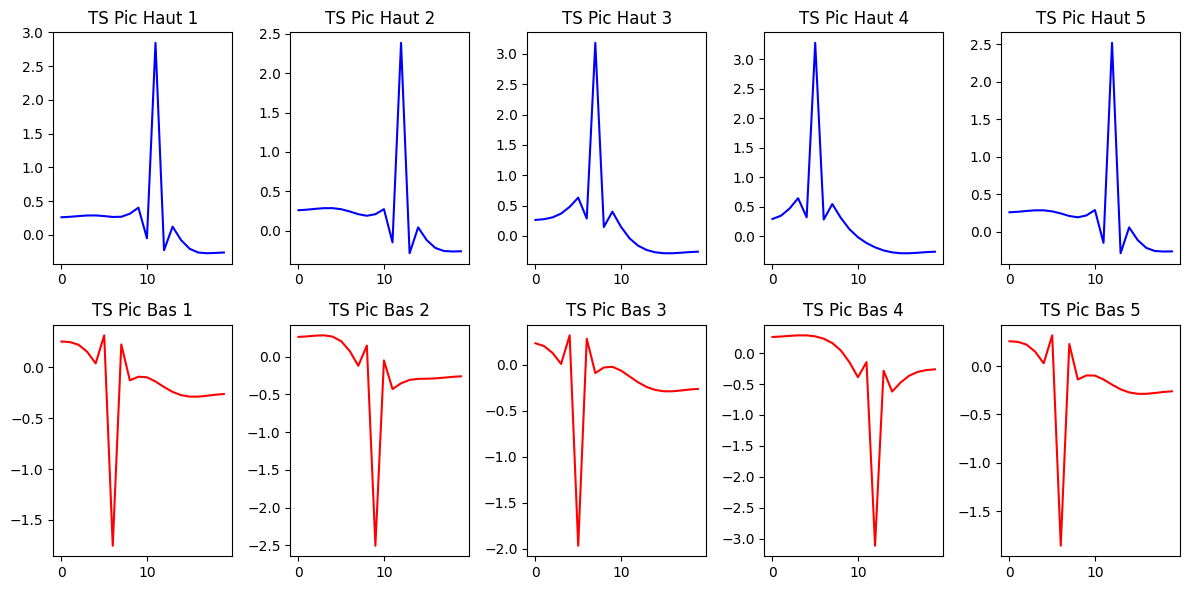

In [12]:
# Définition des paramètres:
n_series = 10  # Nombre total de séries temporelles
n_points = 20  # Nombre de points temporels par série
n_classes = 2  # Nombre de classes (pics vers le haut et vers le bas)
class_labels = ['1', '2']  # Étiquettes des classes

# Fonction pour générer des séries synthétiques lissées avec pics:
"""
Génère des séries temporelles synthétiques avec des pics vers le haut ou le bas.

Paramètres:
- n_series: nombre de séries à générer
- n_points: nombre de points temporels par série
- peak_type: type de pic ('up' pour un pic vers le haut, 'down' pour un pic vers le bas)
- sigma: paramètre de lissage pour la série temporelle

Retourne:
- Un tableau numpy contenant les séries générées
"""
def generate_synthetic_series(n_series, n_points, peak_type='up', sigma=2):
    data = []
    for _ in range(n_series):
        # Générer un signal de base lisse avec un bruit léger
        base_signal = np.sin(np.linspace(0, 2 * np.pi, n_points)) * 0.5
        base_signal = gaussian_filter1d(base_signal, sigma=3)  # Lissage initial
        
        # Ajouter un pic significatif à un emplacement aléatoire
        peak_position = np.random.randint(n_points // 4, 3 * n_points // 4)
        if peak_type == 'up':
            base_signal[peak_position] += np.random.uniform(2, 3)
        elif peak_type == 'down':
            base_signal[peak_position] -= np.random.uniform(2, 3)
        
        # Appliquer un lissage sauf sur le pic
        smoothed_signal = gaussian_filter1d(base_signal, sigma=sigma)
        smoothed_signal[peak_position - 1 : peak_position + 2] = base_signal[peak_position - 1 : peak_position + 2]  # Préserve le pic
        data.append(smoothed_signal)
    
    return np.array(data)

# Fixer la graine pour la reproductibilité
seed_value = 4325
np.random.seed(seed_value)
random.seed(seed_value)

# Générer les séries temporelles
n_per_class = n_series // n_classes  # Nombre de séries par classe
upward_peaks = generate_synthetic_series(n_per_class, n_points, 'up')
downward_peaks = generate_synthetic_series(n_per_class, n_points, 'down')

# Combiner les données et les étiquettes
time_series_data = np.vstack([upward_peaks, downward_peaks])
labels = np.array([class_labels[0]] * n_per_class + [class_labels[1]] * n_per_class)

# Convertir les données en DataFrame
df_10_20 = pd.DataFrame(time_series_data, columns=[f'Time_{i}' for i in range(n_points)])

# Visualisation de quelques exemples
plt.figure(figsize=(12, 6))
for i in range(5):  # Afficher 5 exemples de chaque classe
    plt.subplot(2, 5, i + 1)
    plt.plot(upward_peaks[i], label="Pic Haut", color="blue")
    plt.title(f"TS Pic Haut "+str(i+1))
    plt.subplot(2, 5, i + 6)
    plt.plot(downward_peaks[i], label="Pic Bas", color="red")
    plt.title(f"TS Pic Bas "+str(i+1))
plt.tight_layout()
plt.show()

In [13]:
# Appel de la fonction extractUShapelets sur df avec une longueur des U-shapelets à extraire entre 8 et 15, et k = 2 
shap, serie = extractUShapelets(df_10_20,15,2,8)

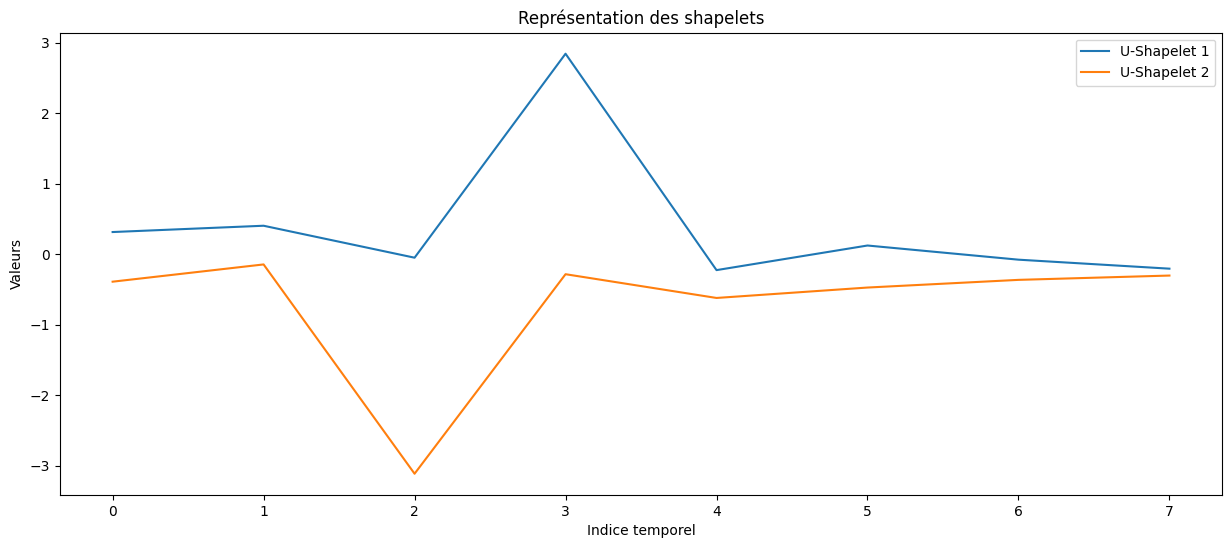

In [23]:
# DataFrame contenant les shapelets extraits
df_shapelet = pd.DataFrame(shap)

# Graphique pour tracer les U-shapelets extraits
plt.figure(figsize=(15, 6))

for i in range(len(shap)) : 
    plt.plot(df_shapelet.iloc[i], label=f'U-Shapelet {i+1}')  
    
# Ajouter un titre et des légendes
plt.title("Représentation des shapelets")
plt.xlabel("Indice temporel")
plt.ylabel("Valeurs")


# Afficher la légende pour chaque série
plt.legend()

# Afficher le graphique
plt.show()


Maintenant, passons au clustering des séries temporelles.

In [24]:
cluster_synth = clusterData(D=df_10_20, Shapelets=shap, k=2)

In [25]:
print(cluster_synth)

(array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0], dtype=int32), [])


L'algorithme reconnait de façon très distincte les classes triviales réprésentant des pics vers le haut et vers le bas

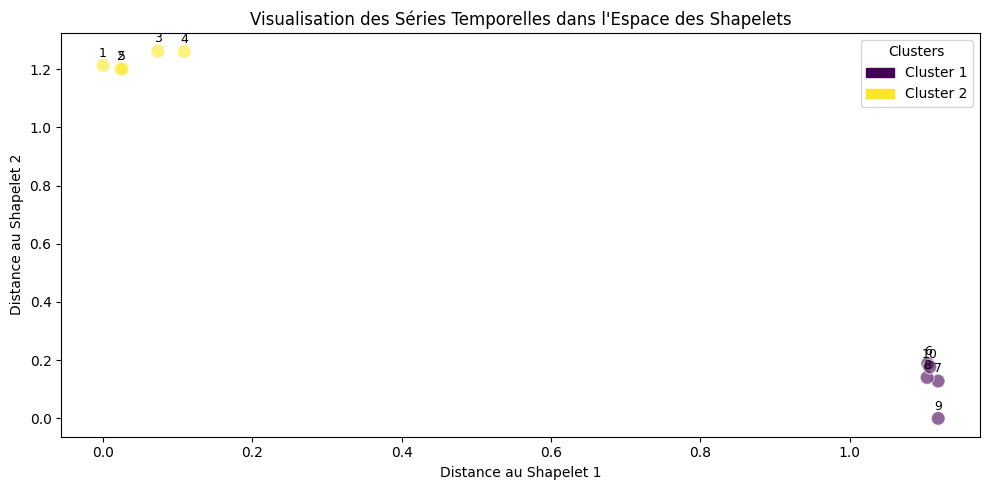

In [33]:
# Représentation graphique des résultats

import matplotlib.patches as mpatches

# 1. Calculer les distances entre les séries temporelles et les shapelets
all_distances = []

for s in shap:  # Pour chaque shapelet
    dis, _ = computeDistance(s, df_10_20)  # Calculer les distances entre cette shapelet et toutes les séries temporelles
    all_distances.append(dis)

# Convertir la liste de distances en une matrice où chaque ligne est une série temporelle et chaque colonne est une distance à un shapelet
distance_matrix = np.array(all_distances).T 

# 2. Récupérer les labels de cluster
cluster_labels, _ = cluster_synth  # Extraire les classes et ignorer la liste

# 3. Visualisation dans l'espace des shapelets
# Ici, on utilise les deux premières distances pour le graphique
x = distance_matrix[:, 0]  # Première dimension (distance au Shapelet 1)
y = distance_matrix[:, 1]  # Deuxième dimension (distance au Shapelet 2)

# 4. Créer le graphique avec les clusters
plt.figure(figsize=(10, 5))

# Créer un scatter plot avec les points colorés selon le cluster auquel ils appartiennent
scatter = plt.scatter(x, y, c=cluster_labels, cmap='viridis', alpha=0.6, edgecolors='w', s=100)

# Titre et axes
plt.title("Visualisation des Séries Temporelles dans l'Espace des Shapelets")
plt.xlabel("Distance au Shapelet 1")
plt.ylabel("Distance au Shapelet 2")

# Ajouter une légende pour les clusters
# Création des handles pour la légende
cluster_patches = [mpatches.Patch(color=scatter.cmap(scatter.norm(i)), label=f"Cluster {i+1}") for i in np.unique(cluster_labels)]
plt.legend(handles=cluster_patches, title="Clusters")

# Ajouter les numéros de séries temporelles au-dessus des points
for i, (xi, yi) in enumerate(zip(x, y)):
    plt.text(xi, yi + 0.02, str(i+1), ha='center', va='bottom', fontsize=9, color='black')

# Afficher le graphique
plt.tight_layout()
plt.show()


On voit que les séries temporelles du Cluster 1 sont plus proches du Shapelet 1. Elles correspondent aux séries de 1 à 5, ayant chacune un pic vers le haut. De même, les séries de 6 à 10, appartenant au Cluster 2, sont les séries avec un pic vers le bas, et sont plus proches du Shapelet 2.

### 2.1.2 Exemple avec 10 séries temporelles de 40 points temporels

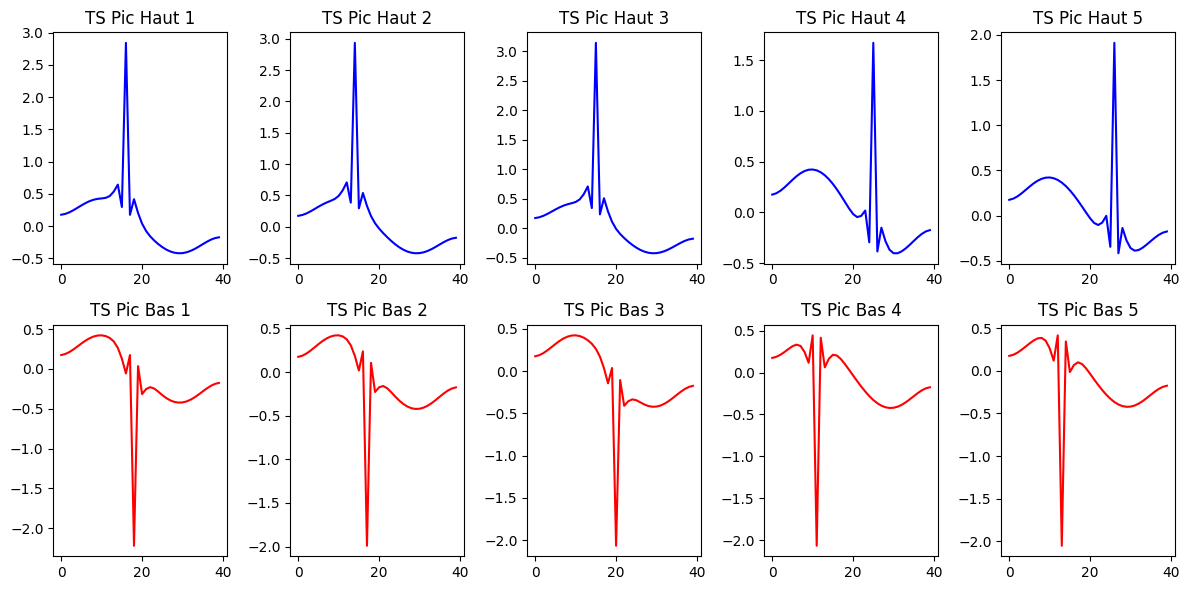

In [34]:
# Définition des paramètres:
n_series = 10  # Nombre total de séries temporelles
n_points = 40  # Nombre de points temporels par série
n_classes = 2  # Nombre de classes (pics vers le haut et vers le bas)
class_labels = ['1', '2']  # Étiquettes des classes

# Fonction pour générer des séries synthétiques lissées avec pics:
"""
Génère des séries temporelles synthétiques avec des pics vers le haut ou le bas.

Paramètres:
- n_series: nombre de séries à générer
- n_points: nombre de points temporels par série
- peak_type: type de pic ('up' pour un pic vers le haut, 'down' pour un pic vers le bas)
- sigma: paramètre de lissage pour la série temporelle

Retourne:
- Un tableau numpy contenant les séries générées
"""
def generate_synthetic_series(n_series, n_points, peak_type='up', sigma=2):
    data = []
    for _ in range(n_series):
        # Générer un signal de base lisse avec un bruit léger
        base_signal = np.sin(np.linspace(0, 2 * np.pi, n_points)) * 0.5
        base_signal = gaussian_filter1d(base_signal, sigma=3)  # Lissage initial
        
        # Ajouter un pic significatif à un emplacement aléatoire
        peak_position = np.random.randint(n_points // 4, 3 * n_points // 4)
        if peak_type == 'up':
            base_signal[peak_position] += np.random.uniform(2, 3)
        elif peak_type == 'down':
            base_signal[peak_position] -= np.random.uniform(2, 3)
        
        # Appliquer un lissage sauf sur le pic
        smoothed_signal = gaussian_filter1d(base_signal, sigma=sigma)
        smoothed_signal[peak_position - 1 : peak_position + 2] = base_signal[peak_position - 1 : peak_position + 2]  # Préserve le pic
        data.append(smoothed_signal)
    
    return np.array(data)

# Fixer la graine pour la reproductibilité
seed_value = 432
np.random.seed(seed_value)
random.seed(seed_value)

# Générer les séries temporelles
n_per_class = n_series // n_classes  # Nombre de séries par classe
upward_peaks = generate_synthetic_series(n_per_class, n_points, 'up')
downward_peaks = generate_synthetic_series(n_per_class, n_points, 'down')

# Combiner les données et les étiquettes
time_series_data = np.vstack([upward_peaks, downward_peaks])
labels = np.array([class_labels[0]] * n_per_class + [class_labels[1]] * n_per_class)

# Convertir les données en DataFrame
df_10_40 = pd.DataFrame(time_series_data, columns=[f'Time_{i}' for i in range(n_points)])

# Visualisation de quelques exemples
plt.figure(figsize=(12, 6))
for i in range(5):  # Afficher 5 exemples de chaque classe
    plt.subplot(2, 5, i + 1)
    plt.plot(upward_peaks[i], label="Pic Haut", color="blue")
    plt.title(f"TS Pic Haut "+str(i+1))
    plt.subplot(2, 5, i + 6)
    plt.plot(downward_peaks[i], label="Pic Bas", color="red")
    plt.title(f"TS Pic Bas "+str(i+1))
plt.tight_layout()
plt.show()

In [35]:
# Appel de la fonction extractUShapelets sur df avec une longueur des U-shapelets à extraire entre 8 et 15, et k = 2 
shap, serie = extractUShapelets(df_10_40,15,2,8)

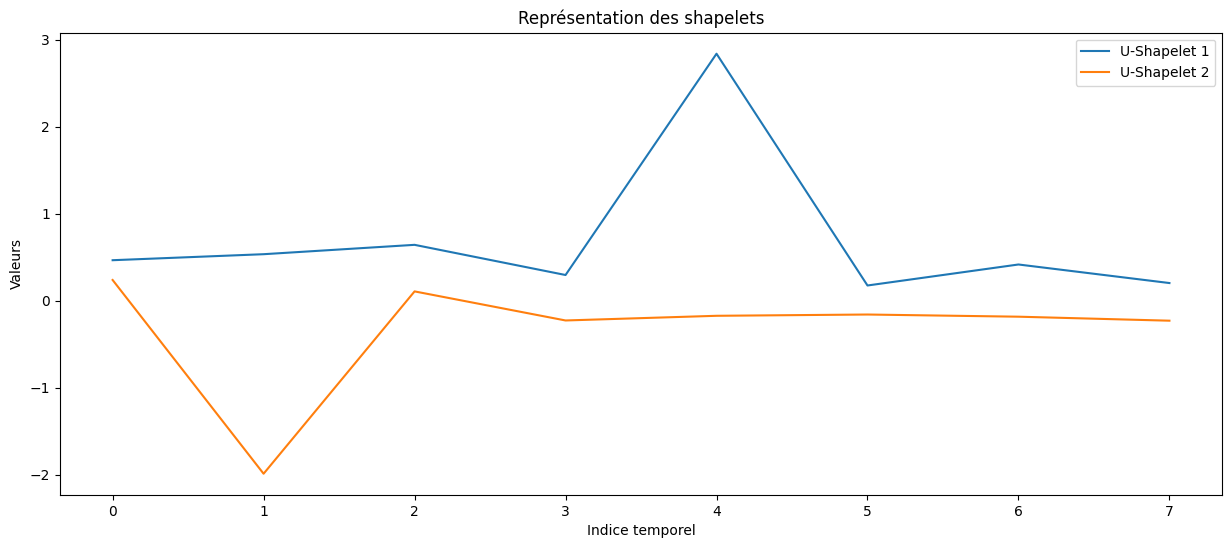

In [36]:
# DataFrame contenant les shapelets extraits
df_shapelet = pd.DataFrame(shap)

# Graphique pour tracer les U-shapelets extraits
plt.figure(figsize=(15, 6))

for i in range(len(shap)) : 
    plt.plot(df_shapelet.iloc[i], label=f'U-Shapelet {i+1}')  
    
# Ajouter un titre et des légendes
plt.title("Représentation des shapelets")
plt.xlabel("Indice temporel")
plt.ylabel("Valeurs")


# Afficher la légende pour chaque série
plt.legend()

# Afficher le graphique
plt.show()


In [37]:
cluster_synth = clusterData(D=df_10_40, Shapelets=shap, k=2)

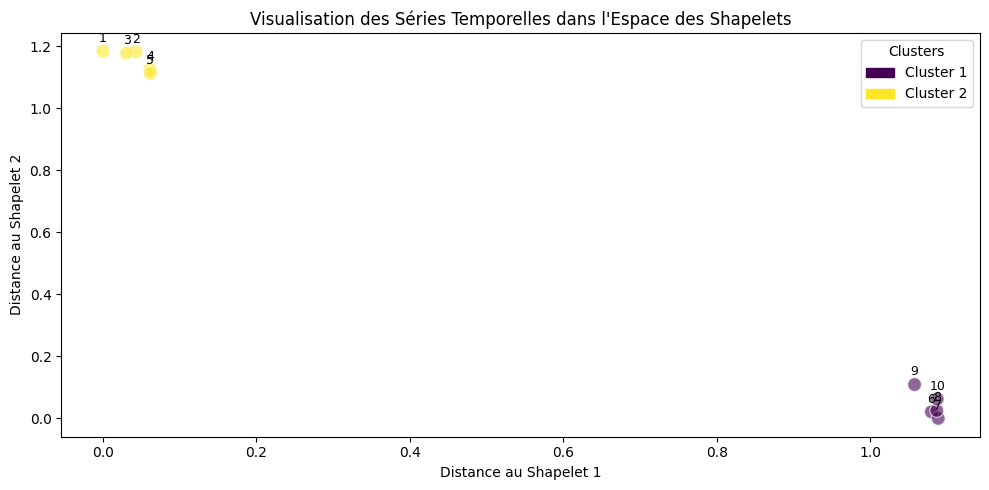

In [39]:
# Représentation graphique des résultats

import matplotlib.patches as mpatches

# 1. Calculer les distances entre les séries temporelles et les shapelets
all_distances = []

for s in shap:  
    dis, _ = computeDistance(s, df_10_40)  # Calculer les distances entre cette shapelet et toutes les séries temporelles
    all_distances.append(dis)

# Convertir la liste de distances en une matrice où chaque ligne est une série temporelle et chaque colonne est une distance à un shapelet
distance_matrix = np.array(all_distances).T  

# 2. Récupérer les labels de cluster
cluster_labels, _ = cluster_synth  # Extraire les labels et ignorer la liste


# 3. Visualisation dans l'espace des shapelets
# Ici, on utilise les deux premières distances pour le graphique
x = distance_matrix[:, 0]  # Première dimension (distance au Shapelet 1)
y = distance_matrix[:, 1]  # Deuxième dimension (distance au Shapelet 2)

# 4. Créer le graphique avec les clusters
plt.figure(figsize=(10, 5))

# Créer un scatter plot avec les points colorés selon le cluster auquel ils appartiennent
scatter = plt.scatter(x, y, c=cluster_labels, cmap='viridis', alpha=0.6, edgecolors='w', s=100)

# Titre et axes
plt.title("Visualisation des Séries Temporelles dans l'Espace des Shapelets")
plt.xlabel("Distance au Shapelet 1")
plt.ylabel("Distance au Shapelet 2")

# Ajouter une légende pour les clusters
# Création des handles pour la légende
cluster_patches = [mpatches.Patch(color=scatter.cmap(scatter.norm(i)), label=f"Cluster {i+1}") for i in np.unique(cluster_labels)]
plt.legend(handles=cluster_patches, title="Clusters")

# Ajouter les numéros de séries temporelles au-dessus des points
for i, (xi, yi) in enumerate(zip(x, y)):
    plt.text(xi, yi + 0.02, str(i+1), ha='center', va='bottom', fontsize=9, color='black')

# Afficher le graphique
plt.tight_layout()
plt.show()


# 3. Application des algorithmes sur des jeux de données de l'article

## 3.1 Dataset Trace

In [62]:
import pandas as pd

# Importation du dataset d'apprentissage
df = pd.read_csv("Trace_TRAIN.ts", header=None, delimiter=":", skiprows=31)

# Extraire les séries temporelles et convertir en valeurs numériques
trace_data  = df[0].str.split(",", expand=True).astype(float)

# Extraire les étiquettes de classe et les convertir en entiers
classe_trace = df[1].astype(int)

On représente les différentes classes de séries temporelles avec des couleurs différentes.

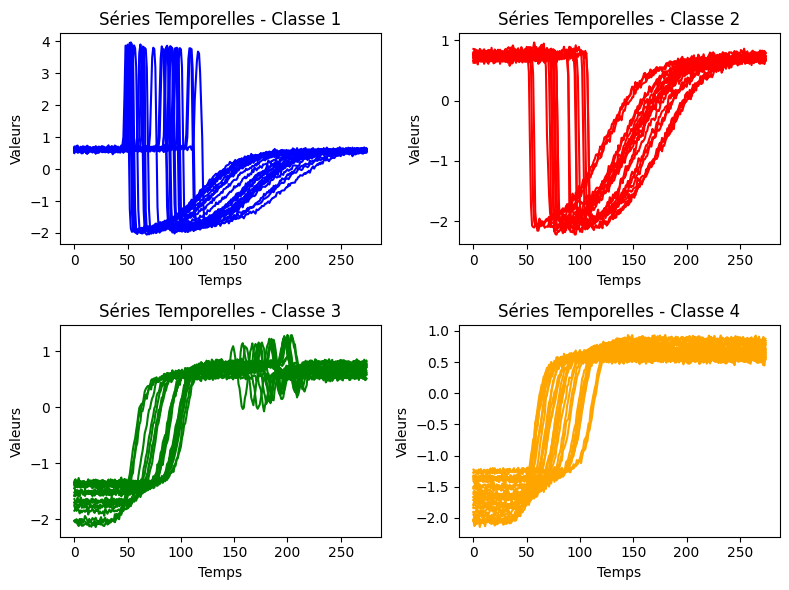

In [63]:
import pandas as pd
import matplotlib.pyplot as plt

# Créer une figure avec 2 lignes et 2 colonnes pour les sous-graphiques
fig, axs = plt.subplots(2, 2, figsize=(8, 6))

# Extraire les séries temporelles de chaque classe
# Classe 1
class_1 = trace_data[classe_trace == 1]
# Classe 2
class_2 = trace_data[classe_trace == 2]
# Classe 3
class_3 = trace_data[classe_trace == 3]
# Classe 4
class_4 = trace_data[classe_trace == 4]

# Afficher les séries temporelles pour chaque classe dans les sous-graphiques
# Première ligne, première colonne (Classe 1)
axs[0, 0].plot(class_1.T, color='blue')
axs[0, 0].set_title("Séries Temporelles - Classe 1")
axs[0, 0].set_xlabel("Temps")
axs[0, 0].set_ylabel("Valeurs")

# Première ligne, deuxième colonne (Classe 2)
axs[0, 1].plot(class_2.T, color='red')
axs[0, 1].set_title("Séries Temporelles - Classe 2")
axs[0, 1].set_xlabel("Temps")
axs[0, 1].set_ylabel("Valeurs")

# Deuxième ligne, première colonne (Classe 3)
axs[1, 0].plot(class_3.T, color='green')
axs[1, 0].set_title("Séries Temporelles - Classe 3")
axs[1, 0].set_xlabel("Temps")
axs[1, 0].set_ylabel("Valeurs")

# Deuxième ligne, deuxième colonne (Classe 4)
axs[1, 1].plot(class_4.T, color='orange')
axs[1, 1].set_title("Séries Temporelles - Classe 4")
axs[1, 1].set_xlabel("Temps")
axs[1, 1].set_ylabel("Valeurs")

# Ajuster la mise en page pour éviter le chevauchement
plt.tight_layout()

# Afficher le graphique
plt.show()


On voit bien que chaque classe de séries temporelles présente une forme particulière. Nous allons voir si l'algorithme d'extraction de shapelets arrive à distinguer ces différentes formes, sans connaître les labels des classes.

Dans la suite, nous allons tester les algorithmes d'extraction des shapelets et de clustering, avec différents paramètres.

**Exemple avec une longueur fixe de shapelet**

In [83]:
# Appel de la fonction extractUShapelets sur trace_data avec une longueur des U-shapelets fixée à 33, et k = 4 

import time

# Enregistrez le temps de départ
start_time = time.time()

# Exécution de la fonction extractUShapelets
shap_trace, serie_trace = extractUShapelets(trace_data, 33, 4, 33)

# Enregistrez le temps de fin
end_time = time.time()

# Calcul du temps écoulé
execution_time = end_time - start_time

# Affichage du temps d'exécution
print(f"Temps d'exécution de extractUShapelets sur le dataset Trace (avec len(shapelet) fixée à 33) : {execution_time:.4f} secondes")


Temps d'exécution de extractUShapelets sur le dataset Trace (avec len(shapelet) fixée à 33) : 34.1110 secondes


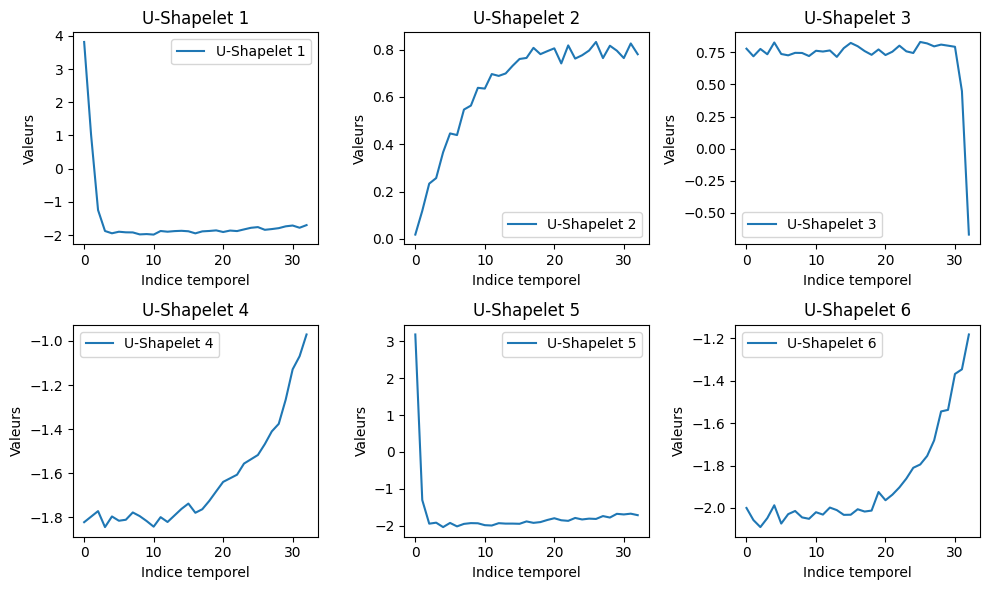

In [143]:

# DataFrame contenant les shapelets extraits
trace_shapelet = pd.DataFrame(shap_trace)

# Déterminer le nombre de colonnes et de lignes nécessaires
n = len(shap_trace)
cols = 3  # Par exemple, vous pouvez ajuster ce nombre
rows = (n // cols) + (n % cols > 0)  # Calcul des lignes nécessaires pour le nombre d'éléments

# Créer une figure avec des sous-graphiques
fig, axes = plt.subplots(rows, cols, figsize=(10, 3 * rows))

# Aplatir la liste des axes pour faciliter l'accès
axes = axes.flatten()

# Tracer chaque shapelet dans un sous-graphe
for i in range(n):
    axes[i].plot(trace_shapelet.iloc[i], label=f'U-Shapelet {i+1}')
    axes[i].set_title(f'U-Shapelet {i+1}')
    axes[i].set_xlabel("Indice temporel")
    axes[i].set_ylabel("Valeurs")
    axes[i].legend()

# Supprimer les axes inutilisés (si n < rows * cols)
for i in range(n, len(axes)):
    fig.delaxes(axes[i])

# Ajuster l'espacement entre les graphiques
plt.tight_layout()

# Afficher la figure
plt.show()


In [1395]:
cluster_trace, inerties_trace = clusterData(D=trace_data, Shapelets=shap_trace, k=4)
print(randIndex(classe_trace,cluster_trace))

0.9696969696969697


Exemple avec des longueurs entre 5 et 80

In [ ]:

import time

# Enregistrez le temps de départ
start_time = time.time()

# Exécution de la fonction extractUShapelets
shap_trace1, serie_trace1 = extractUShapelets(trace_data, 80, 4, 5)

# Enregistrez le temps de fin
end_time = time.time()

# Calcul du temps écoulé
execution_time = end_time - start_time

# Affichage du temps d'exécution
print(f"Temps d'exécution de extractUShapelets sur le dataset Trace (avec len(shapelet) entre 5 et 80) : {execution_time:.4f} secondes")


Temps d'exécution de extractUShapelets sur le dataset Trace (avec len(shapelet) entre 5 et 80) : 1792.0194 secondes

In [213]:
len(shap_trace1)

7

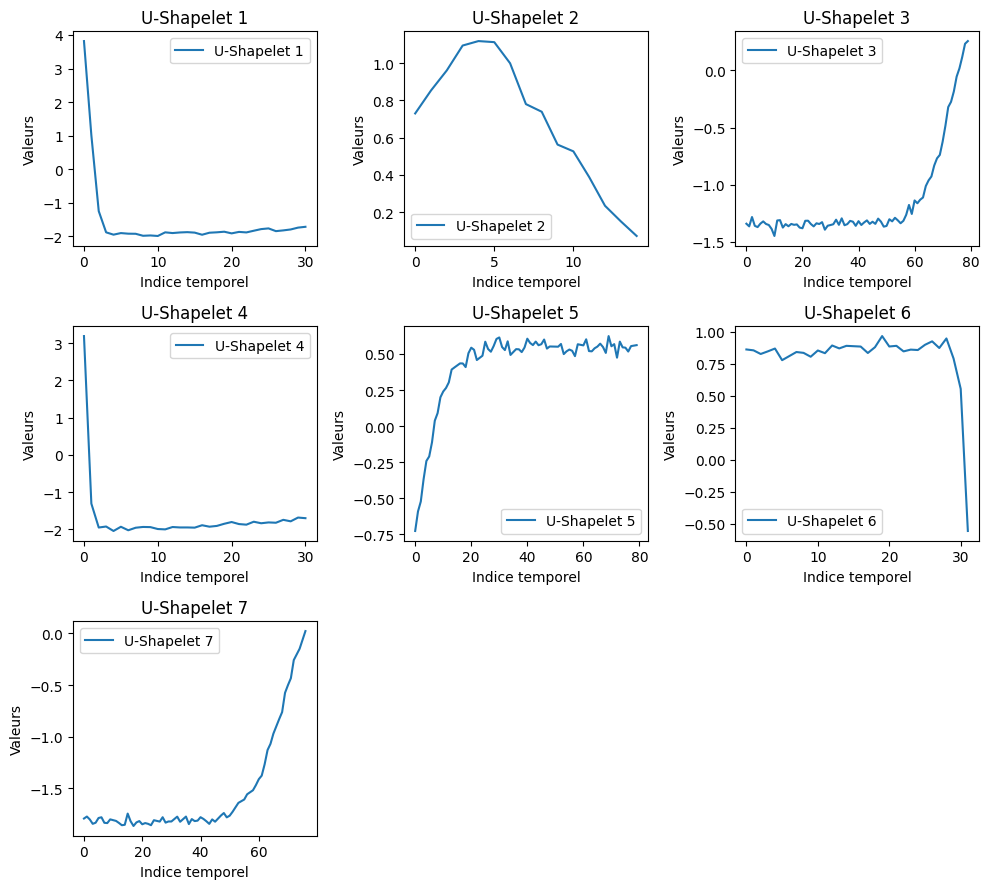

In [ ]:
# DataFrame contenant les shapelets extraits
trace_shapelet = pd.DataFrame(shap_trace1)

# Déterminer le nombre de colonnes et de lignes nécessaires
n = len(shap_trace1)
cols = 3  # Par exemple, vous pouvez ajuster ce nombre
rows = (n // cols) + (n % cols > 0)  # Calcul des lignes nécessaires pour le nombre d'éléments

# Créer une figure avec des sous-graphiques
fig, axes = plt.subplots(rows, cols, figsize=(10, 3 * rows))

# Aplatir la liste des axes pour faciliter l'accès
axes = axes.flatten()

# Tracer chaque shapelet dans un sous-graphe
for i in range(n):
    axes[i].plot(trace_shapelet.iloc[i], label=f'U-Shapelet {i+1}')
    axes[i].set_title(f'U-Shapelet {i+1}')
    axes[i].set_xlabel("Indice temporel")
    axes[i].set_ylabel("Valeurs")
    axes[i].legend()

# Supprimer les axes inutilisés (si n < rows * cols)
for i in range(n, len(axes)):
    fig.delaxes(axes[i])

# Ajuster l'espacement entre les graphiques
plt.tight_layout()

# Afficher la figure
plt.show()


In [1403]:
cluster_trace, inerties_trace = clusterData(D=trace_data, Shapelets=shap_trace1, k=4)

# Indice de rand
print(randIndex(classe_trace, cluster_trace))

1.0


**Réprésentation des clusters en deux dimensions**

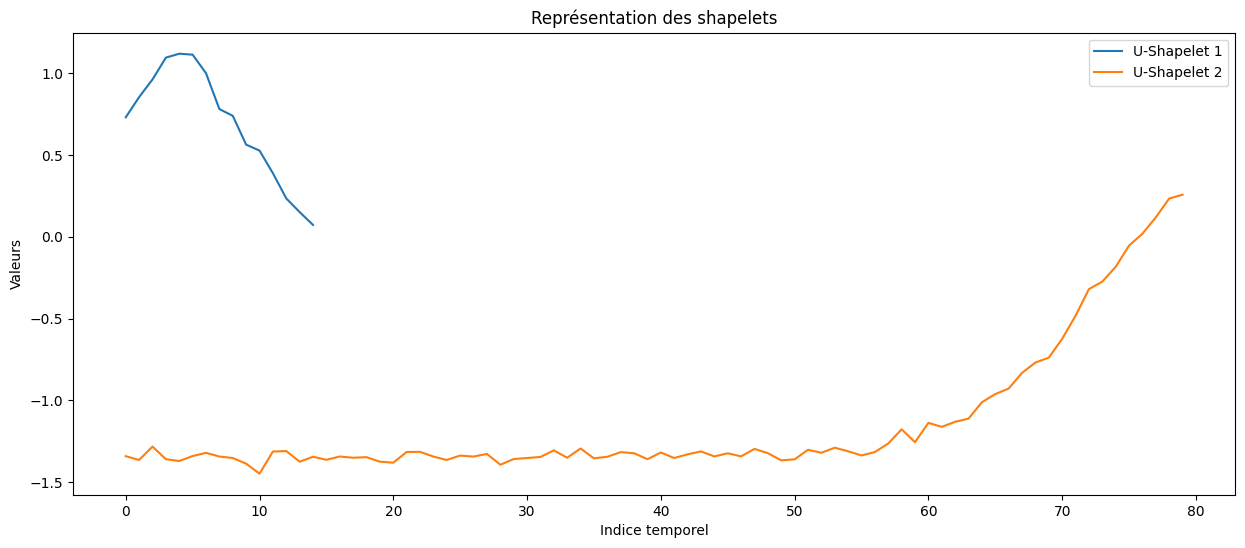

In [1404]:
shap12 = shap_trace1[1:3]

# DataFrame contenant les shapelets extraits
df_shapelet = pd.DataFrame(shap12)

# Graphique pour tracer les U-shapelets extraits
plt.figure(figsize=(15, 6))

for i in range(len(shap12)) : 
    plt.plot(df_shapelet.iloc[i], label=f'U-Shapelet {i+1}')  
    
# Ajouter un titre et des légendes
plt.title("Représentation des shapelets")
plt.xlabel("Indice temporel")
plt.ylabel("Valeurs")


# Afficher la légende pour chaque série
plt.legend()

# Afficher le graphique
plt.show()


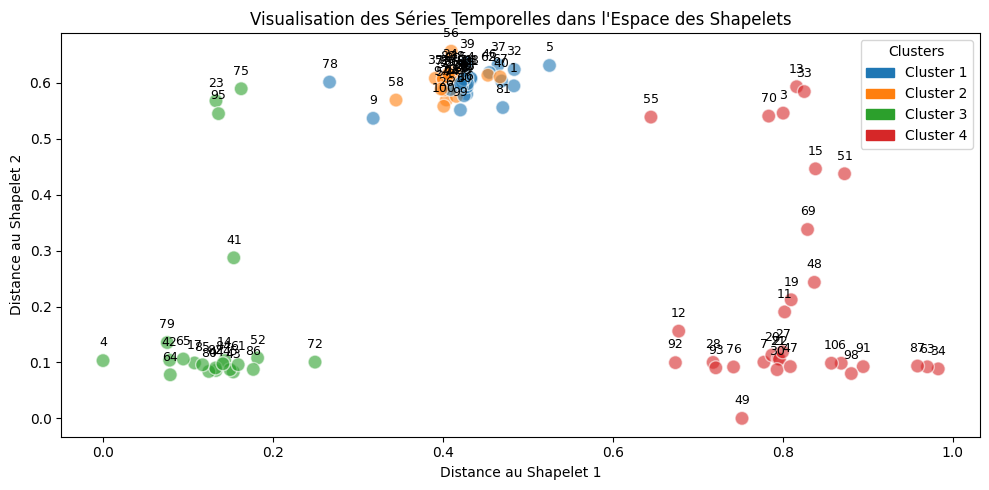

In [1405]:
import matplotlib.pyplot as plt

import numpy as np

# 1. Calculer les distances entre les séries temporelles et les shapelets
all_distances = []

for s in shap12:  # Pour chaque shapelet
    dis, _ = computeDistance(s, trace_data)  # Calculer les distances entre cette shapelet et toutes les séries temporelles
    all_distances.append(dis)

# Convertir la liste de distances en une matrice (lignes : séries temporelles, colonnes : shapelets)
distance_matrix = np.array(all_distances).T  


# 3. Sélectionner les deux premières distances pour le graphique
x = distance_matrix[:, 0]  # Distance au Shapelet 1
y = distance_matrix[:, 1]  # Distance au Shapelet 2

# 4. Adapter les couleurs aux clusters
cmap = plt.get_cmap('tab10')  # Palette de couleurs adaptées aux catégories discrètes
unique_clusters = np.unique(classe_trace)  # Identifier les clusters uniques

# Associer chaque cluster à une couleur
color_dict = {cluster: cmap(i) for i, cluster in enumerate(unique_clusters)}

# Générer les couleurs pour chaque point
colors = [color_dict[label] for label in classe_trace]

# 5. Création du graphique
plt.figure(figsize=(10, 5))

# Créer un scatter plot avec les points colorés selon leur cluster
scatter = plt.scatter(x, y, c=colors, alpha=0.6, edgecolors='w', s=100)

# Ajouter une légende pour les clusters
patches = [mpatches.Patch(color=color_dict[label], label=f"Cluster {label}") for label in unique_clusters]
plt.legend(handles=patches, title="Clusters")

# Ajouter un titre et nommer les axes
plt.title("Visualisation des Séries Temporelles dans l'Espace des Shapelets")
plt.xlabel("Distance au Shapelet 1")
plt.ylabel("Distance au Shapelet 2")

# Ajouter les numéros de séries temporelles au-dessus des points
for i, (xi, yi) in enumerate(zip(x, y)):
    plt.text(xi, yi + 0.02, str(i + 1), ha='center', va='bottom', fontsize=9, color='black')

# Afficher le graphique
plt.tight_layout()
plt.show()


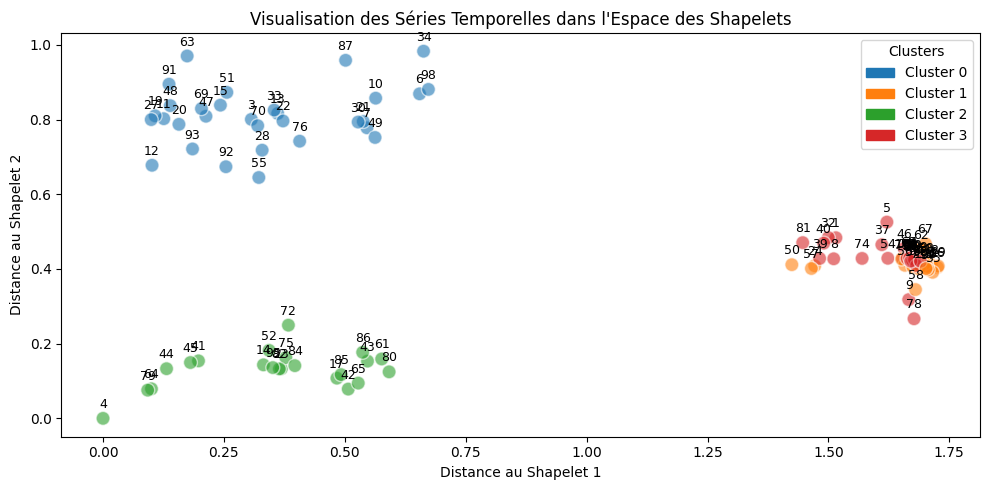

In [316]:

# 1. Calculer les distances entre les séries temporelles et les shapelets
all_distances = []

for s in shap12:  # Pour chaque shapelet
    dis, _ = computeDistance(s, trace_data)  # Calculer les distances entre cette shapelet et toutes les séries temporelles
    all_distances.append(dis)

# Convertir la liste de distances en une matrice (lignes : séries temporelles, colonnes : shapelets)
distance_matrix = np.array(all_distances).T  


# 3. Sélectionner les deux premières distances pour le graphique
x = distance_matrix[:, 0]  # Distance au Shapelet 1
y = distance_matrix[:, 1]  # Distance au Shapelet 2

# 4. Adapter les couleurs aux clusters
cmap = plt.get_cmap('tab10')  # Palette de couleurs adaptées aux catégories discrètes
unique_clusters = np.unique(list(cluster_trace.values()))  # Identifier les clusters uniques

# Associer chaque cluster à une couleur
color_dict = {cluster: cmap(i) for i, cluster in enumerate(unique_clusters)}

# Générer les couleurs pour chaque point
colors = [color_dict[label] for label in list(cluster_trace.values())]

# 5. Création du graphique
plt.figure(figsize=(10, 5))

# Créer un scatter plot avec les points colorés selon leur cluster
scatter = plt.scatter(x, y, c=colors, alpha=0.6, edgecolors='w', s=100)

# Ajouter une légende pour les clusters
patches = [mpatches.Patch(color=color_dict[label], label=f"Cluster {label}") for label in unique_clusters]
plt.legend(handles=patches, title="Clusters")

# Ajouter un titre et nommer les axes
plt.title("Visualisation des Séries Temporelles dans l'Espace des Shapelets")
plt.xlabel("Distance au Shapelet 1")
plt.ylabel("Distance au Shapelet 2")

# Ajouter les numéros de séries temporelles au-dessus des points
for i, (xi, yi) in enumerate(zip(x, y)):
    plt.text(xi, yi + 0.02, str(i + 1), ha='center', va='bottom', fontsize=9, color='black')

# Afficher le graphique
plt.tight_layout()
plt.show()


**Exemple avec un intervalle de 1 à 275**

In [ ]:

import time

# Enregistrez le temps de départ
start_time = time.time()

# Exécution de la fonction extractUShapelets
shap_trace2, serie_trace2 = extractUShapelets(trace_data, 275, 4, 1)

# Enregistrez le temps de fin
end_time = time.time()

# Calcul du temps écoulé
execution_time = end_time - start_time

# Convertir le temps en minutes et secondes
execution_minutes = execution_time // 60
execution_seconds = execution_time % 60

# Afficher le temps d'exécution en secondes et en minutes
print(f"Temps d'exécution de extractUShapelets sur le dataset Trace (avec len(shapelet) entre 1 et 275) : {execution_time:.4f} secondes")

Temps d'exécution de extractUShapelets sur le dataset Trace (avec len(shapelet) entre 1 et 275) : 5118.8863 secondes

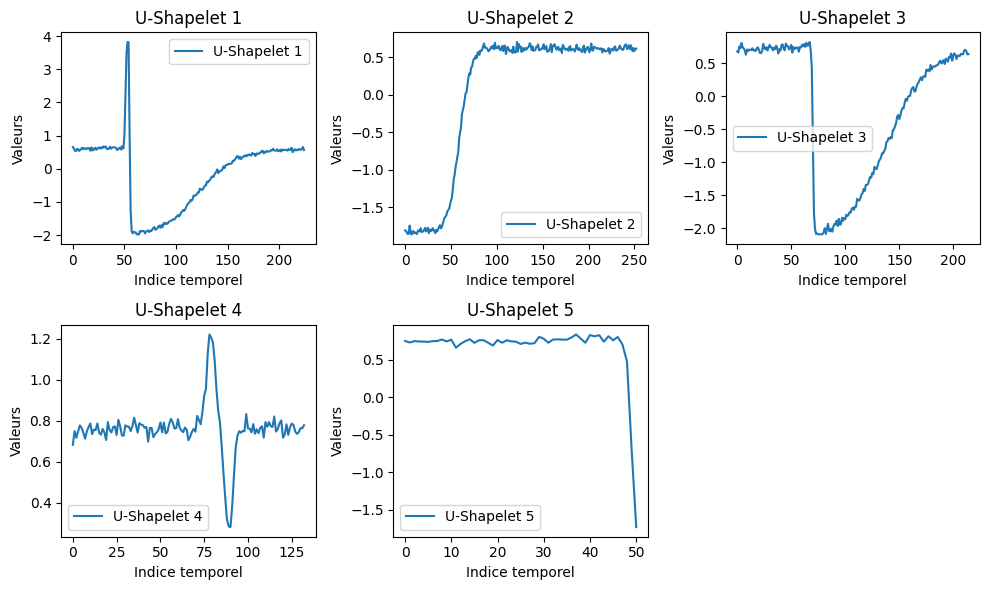

In [343]:

# DataFrame contenant les shapelets extraits
trace_shapelet = pd.DataFrame(shap_trace2)

# Déterminer le nombre de colonnes et de lignes nécessaires
n = len(shap_trace2)
cols = 3  # Par exemple, vous pouvez ajuster ce nombre
rows = (n // cols) + (n % cols > 0)  # Calcul des lignes nécessaires pour le nombre d'éléments

# Créer une figure avec des sous-graphiques
fig, axes = plt.subplots(rows, cols, figsize=(10, 3 * rows))

# Aplatir la liste des axes pour faciliter l'accès
axes = axes.flatten()

# Tracer chaque shapelet dans un sous-graphe
for i in range(n):
    axes[i].plot(trace_shapelet.iloc[i], label=f'U-Shapelet {i+1}')
    axes[i].set_title(f'U-Shapelet {i+1}')
    axes[i].set_xlabel("Indice temporel")
    axes[i].set_ylabel("Valeurs")
    axes[i].legend()

# Supprimer les axes inutilisés (si n < rows * cols)
for i in range(n, len(axes)):
    fig.delaxes(axes[i])

# Ajuster l'espacement entre les graphiques
plt.tight_layout()

# Afficher la figure
plt.show()


In [1407]:

# Clustering et indice de rand
cluster_trace,_ = clusterData(D=trace_data, Shapelets=shap_trace2, k=4)
print(randIndex(classe_trace, cluster_trace))

1.0


**Représentation des clusters en deux dimensions**

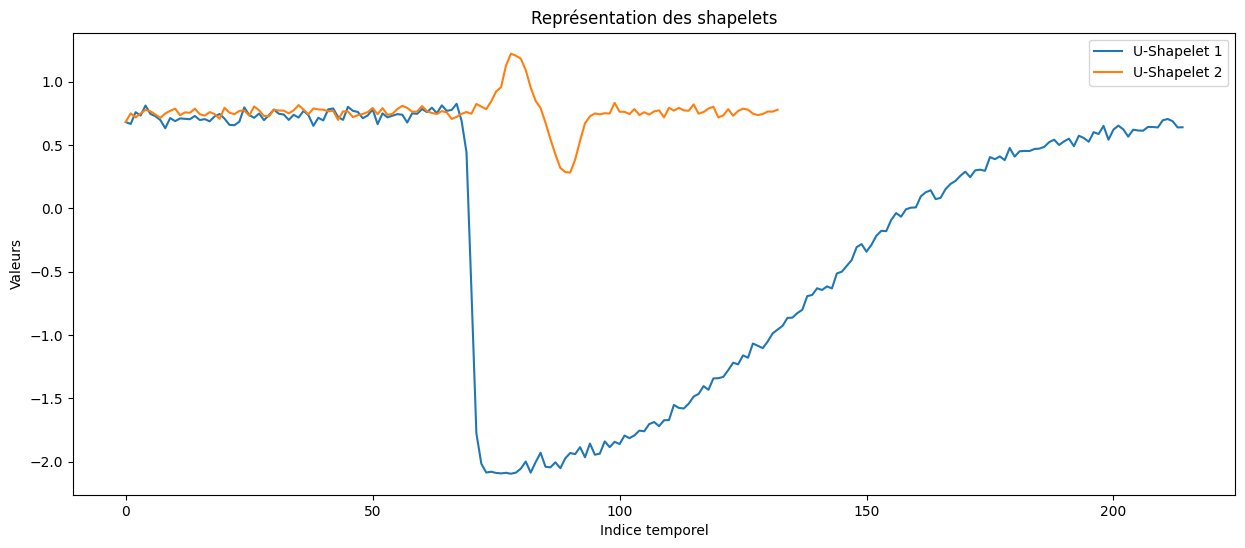

In [359]:
shap12 = shap_trace2[2:4]

# DataFrame contenant les shapelets extraits
df_shapelet = pd.DataFrame(shap12)

# Graphique pour tracer les U-shapelets extraits
plt.figure(figsize=(15, 6))

for i in range(len(shap12)) : 
    plt.plot(df_shapelet.iloc[i], label=f'U-Shapelet {i+1}')  
    
# Ajouter un titre et des légendes
plt.title("Représentation des shapelets")
plt.xlabel("Indice temporel")
plt.ylabel("Valeurs")


# Afficher la légende pour chaque série
plt.legend()

# Afficher le graphique
plt.show()


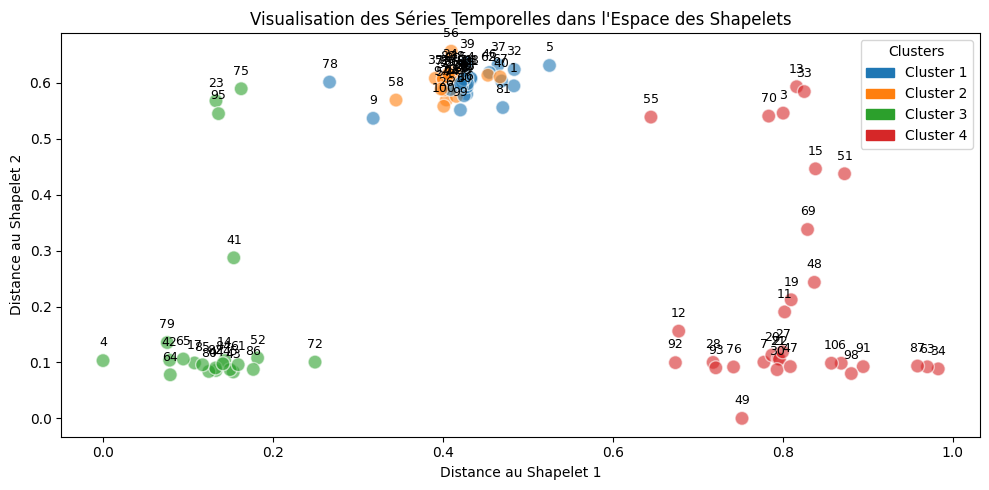

In [1409]:

# 1. Calculer les distances entre les séries temporelles et les shapelets
all_distances = []

for s in shap12:  # Pour chaque shapelet
    dis, _ = computeDistance(s, trace_data)  # Calculer les distances entre cette shapelet et toutes les séries temporelles
    all_distances.append(dis)

# Convertir la liste de distances en une matrice (lignes : séries temporelles, colonnes : shapelets)
distance_matrix = np.array(all_distances).T  


# 3. Sélectionner les deux premières distances pour le graphique
x = distance_matrix[:, 0]  # Distance au Shapelet 1
y = distance_matrix[:, 1]  # Distance au Shapelet 2

# 4. Adapter les couleurs aux clusters
cmap = plt.get_cmap('tab10')  # Palette de couleurs adaptées aux catégories discrètes
unique_clusters = np.unique(classe_trace)  # Identifier les clusters uniques

# Associer chaque cluster à une couleur
color_dict = {cluster: cmap(i) for i, cluster in enumerate(unique_clusters)}

# Générer les couleurs pour chaque point
colors = [color_dict[label] for label in classe_trace]

# 5. Création du graphique
plt.figure(figsize=(10, 5))

# Créer un scatter plot avec les points colorés selon leur cluster
scatter = plt.scatter(x, y, c=colors, alpha=0.6, edgecolors='w', s=100)

# Ajouter une légende pour les clusters
patches = [mpatches.Patch(color=color_dict[label], label=f"Cluster {label}") for label in unique_clusters]
plt.legend(handles=patches, title="Clusters")

# Ajouter un titre et nommer les axes
plt.title("Visualisation des Séries Temporelles dans l'Espace des Shapelets")
plt.xlabel("Distance au Shapelet 1")
plt.ylabel("Distance au Shapelet 2")

# Ajouter les numéros de séries temporelles au-dessus des points
for i, (xi, yi) in enumerate(zip(x, y)):
    plt.text(xi, yi + 0.02, str(i + 1), ha='center', va='bottom', fontsize=9, color='black')

# Afficher le graphique
plt.tight_layout()
plt.show()


## 3.2 Dataset ECG

In [376]:
# Importation des données 

ecg_dataset = pd.read_csv("ECG5000_TRAIN.ts", header=None, delimiter=":", skiprows=9)

# Extraire les séries temporelles et convertir en valeurs numériques
ecg_data  = ecg_dataset[0].str.split(",", expand=True).astype(float)

# Extraire les étiquettes de classe et les convertir en entiers
classe_ecg = ecg_dataset[1].astype(int)


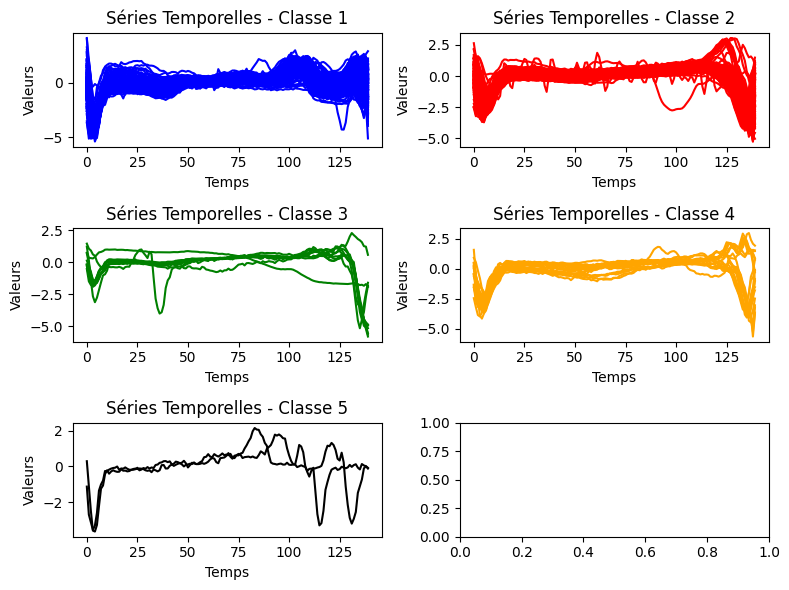

In [387]:
import pandas as pd
import matplotlib.pyplot as plt

# Créer une figure avec 2 lignes et 2 colonnes pour les sous-graphiques
fig, axs = plt.subplots(3, 2, figsize=(8, 6))

# Extraire les séries temporelles de chaque classe
# Classe 1
class_1 = ecg_data[classe_ecg == 1]
# Classe 2
class_2 = ecg_data[classe_ecg == 2]
# Classe 3
class_3 = ecg_data[classe_ecg == 3]
# Classe 4
class_4 = ecg_data[classe_ecg == 4]
# Classe 5
class_5 = ecg_data[classe_ecg == 5]

# Afficher les séries temporelles pour chaque classe dans les sous-graphiques
# Première ligne, première colonne (Classe 1)
axs[0, 0].plot(class_1.T, color='blue')
axs[0, 0].set_title("Séries Temporelles - Classe 1")
axs[0, 0].set_xlabel("Temps")
axs[0, 0].set_ylabel("Valeurs")

# Première ligne, deuxième colonne (Classe 2)
axs[0, 1].plot(class_2.T, color='red')
axs[0, 1].set_title("Séries Temporelles - Classe 2")
axs[0, 1].set_xlabel("Temps")
axs[0, 1].set_ylabel("Valeurs")

# Deuxième ligne, première colonne (Classe 3)
axs[1, 0].plot(class_3.T, color='green')
axs[1, 0].set_title("Séries Temporelles - Classe 3")
axs[1, 0].set_xlabel("Temps")
axs[1, 0].set_ylabel("Valeurs")

# Deuxième ligne, deuxième colonne (Classe 4)
axs[1, 1].plot(class_4.T, color='orange')
axs[1, 1].set_title("Séries Temporelles - Classe 4")
axs[1, 1].set_xlabel("Temps")
axs[1, 1].set_ylabel("Valeurs")

# Deuxième ligne, deuxième colonne (Classe 5)
axs[2, 0].plot(class_5.T, color='black')
axs[2, 0].set_title("Séries Temporelles - Classe 5")
axs[2, 0].set_xlabel("Temps")
axs[2, 0].set_ylabel("Valeurs")


# Ajuster la mise en page pour éviter le chevauchement
plt.tight_layout()

# Afficher le graphique
plt.show()


In [ ]:

import time

# Enregistrez le temps de départ
start_time = time.time()

# Appel de la fonction extractUShapelets sur trace_data avec une longueur des U-shapelets à extraire entre 50 et 200, et k = 4 
shap_ecg, serie_ecg = extractUShapelets(ecg_data,140,5,1)

# Enregistrez le temps de fin
end_time = time.time()

# Calcul du temps écoulé
execution_time = end_time - start_time

# Affichage du temps d'exécution
print(f"Temps d'exécution de extractUShapelets sur le dataset ECG (avec len(shapelet) entre 5 et 140) : {execution_time:.4f} secondes")


Temps d'exécution de extractUShapelets sur le dataset ECG (avec len(shapelet) entre 5 et 140) : 8767.6314 secondes


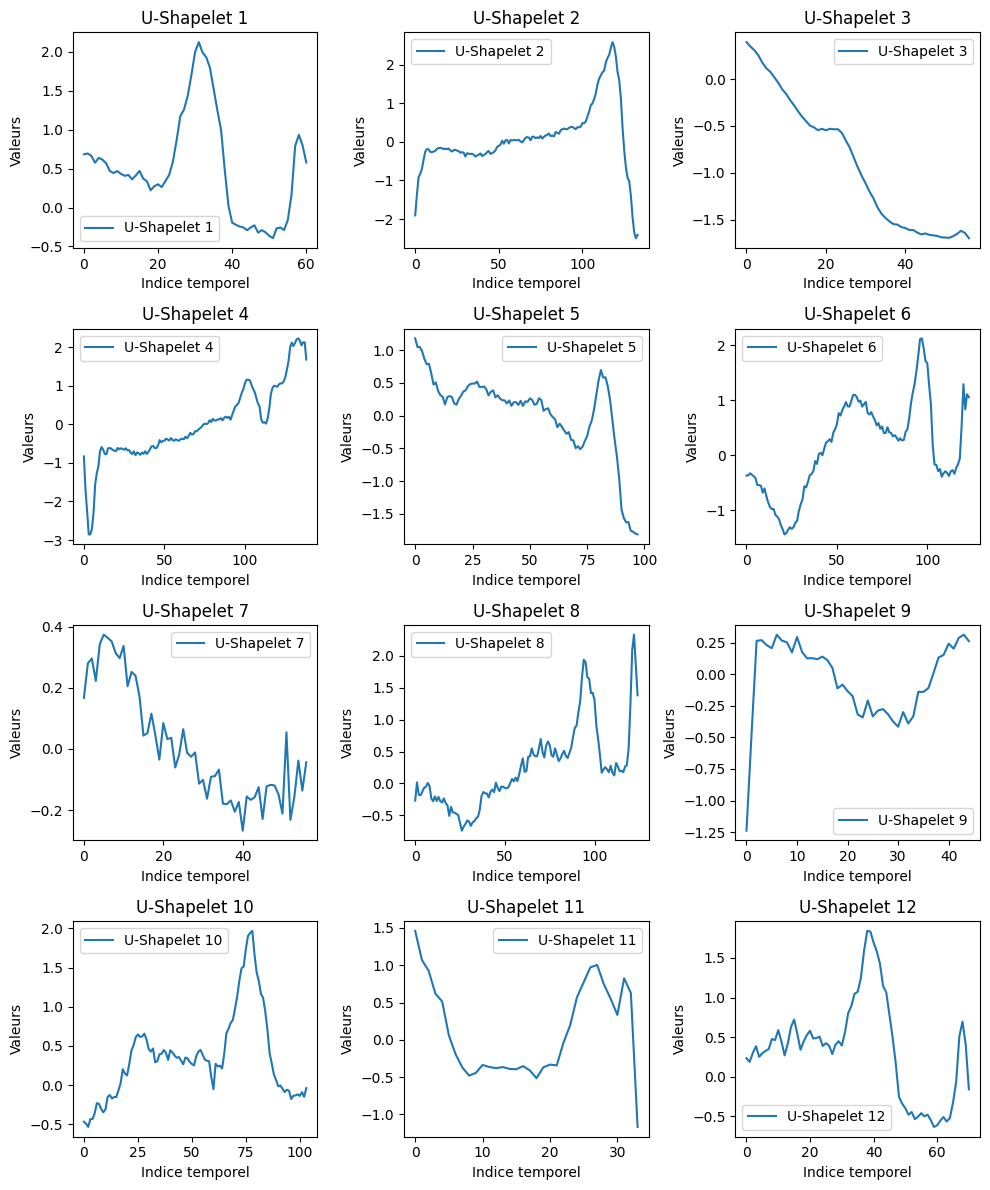

In [392]:
import matplotlib.pyplot as plt
import pandas as pd

# DataFrame contenant les shapelets extraits
ecg_shapelet = pd.DataFrame(shap_ecg)

# Déterminer le nombre de colonnes et de lignes nécessaires
n = len(shap_ecg)
cols = 3  # Par exemple, vous pouvez ajuster ce nombre
rows = (n // cols) + (n % cols > 0)  # Calcul des lignes nécessaires pour le nombre d'éléments

# Créer une figure avec des sous-graphiques
fig, axes = plt.subplots(rows, cols, figsize=(10, 3 * rows))

# Aplatir la liste des axes pour faciliter l'accès
axes = axes.flatten()

# Tracer chaque shapelet dans un sous-graphe
for i in range(n):
    axes[i].plot(ecg_shapelet.iloc[i], label=f'U-Shapelet {i+1}')
    axes[i].set_title(f'U-Shapelet {i+1}')
    axes[i].set_xlabel("Indice temporel")
    axes[i].set_ylabel("Valeurs")
    axes[i].legend()

# Supprimer les axes inutilisés (si n < rows * cols)
for i in range(n, len(axes)):
    fig.delaxes(axes[i])

# Ajuster l'espacement entre les graphiques
plt.tight_layout()

# Afficher la figure
plt.show()


In [1411]:
cluster_ecg,_ = clusterData(D=ecg_data, Shapelets=shap_ecg, k=5)
print(randIndex(classe_ecg, cluster_ecg))

0.7259158316633266


## 3.3 Dataset Gun_Point

In [412]:
# Importation des données 

gun_point_dataset = pd.read_csv("GunPoint_TRAIN.ts", header=None, delimiter=":", skiprows=19)

# Extraire les séries temporelles et convertir en valeurs numériques
gun_point_data  = gun_point_dataset[0].str.split(",", expand=True).astype(float)

# Extraire les étiquettes de classe et les convertir en entiers
classe_gun_point = gun_point_dataset[1].astype(int)


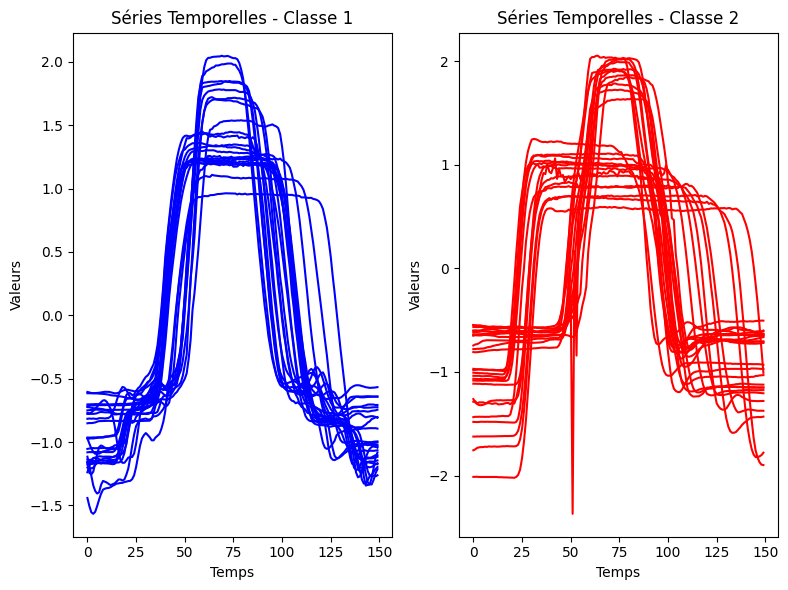

In [1415]:

# Créer une figure avec 2 lignes et 2 colonnes pour les sous-graphiques
fig, axs = plt.subplots(1, 2, figsize=(8, 6))

# Extraire les séries temporelles de chaque classe
# Classe 1
class_1 = gun_point_data[classe_gun_point == 1]
# Classe 2
class_2 = gun_point_data[classe_gun_point == 2]


# Afficher les séries temporelles pour chaque classe dans les sous-graphiques
# Première ligne, première colonne (Classe 1)
axs[ 0].plot(class_1.T, color='blue')
axs[ 0].set_title("Séries Temporelles - Classe 1")
axs[0].set_xlabel("Temps")
axs[ 0].set_ylabel("Valeurs")

# Première ligne, deuxième colonne (Classe 2)
axs[1].plot(class_2.T, color='red')
axs[ 1].set_title("Séries Temporelles - Classe 2")
axs[ 1].set_xlabel("Temps")
axs[ 1].set_ylabel("Valeurs")



# Ajuster la mise en page pour éviter le chevauchement
plt.tight_layout()

# Afficher le graphique
plt.show()


In [ ]:
import time

# Enregistrez le temps de départ
start_time = time.time()

# Appel de la fonction extractUShapelets sur trace_data avec une longueur des U-shapelets à extraire entre 50 et 200, et k = 4 
shap_gun_point, serie_gun_point = extractUShapelets(gun_point_data,30,2,1)

# Enregistrez le temps de fin
end_time = time.time()

# Calcul du temps écoulé
execution_time = end_time - start_time

# Affichage du temps d'exécution
print(f"Temps d'exécution de extractUShapelets sur le dataset Gun Point (avec len(shapelet) entre 1 et 30) : {execution_time:.4f} secondes")


Temps d'exécution de extractUShapelets sur le dataset Gun Point (avec len(shapelet) entre 1 et 30) : 181.1591 secondes


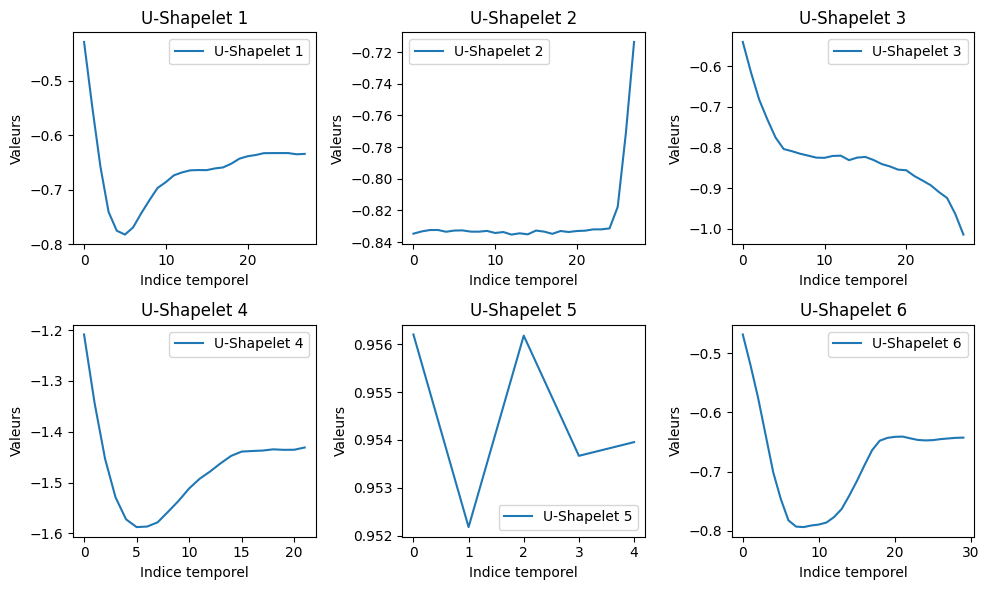

In [ ]:
# DataFrame contenant les shapelets extraits
gun_point_shapelet = pd.DataFrame(shap_gun_point)

# Déterminer le nombre de colonnes et de lignes nécessaires
n = len(shap_gun_point)
cols = 3  # Par exemple, vous pouvez ajuster ce nombre
rows = (n // cols) + (n % cols > 0)  # Calcul des lignes nécessaires pour le nombre d'éléments

# Créer une figure avec des sous-graphiques
fig, axes = plt.subplots(rows, cols, figsize=(10, 3 * rows))

# Aplatir la liste des axes pour faciliter l'accès
axes = axes.flatten()

# Tracer chaque shapelet dans un sous-graphe
for i in range(n):
    axes[i].plot(gun_point_shapelet.iloc[i], label=f'U-Shapelet {i+1}')
    axes[i].set_title(f'U-Shapelet {i+1}')
    axes[i].set_xlabel("Indice temporel")
    axes[i].set_ylabel("Valeurs")
    axes[i].legend()

# Supprimer les axes inutilisés (si n < rows * cols)
for i in range(n, len(axes)):
    fig.delaxes(axes[i])

# Ajuster l'espacement entre les graphiques
plt.tight_layout()

# Afficher la figure
plt.show()


In [1427]:
cluster_gun_point,_ = clusterData(D=gun_point_data, Shapelets=shap_gun_point, k=2)
print(randIndex(classe_gun_point,cluster_gun_point))

0.649795918367347


*Labels prédis*

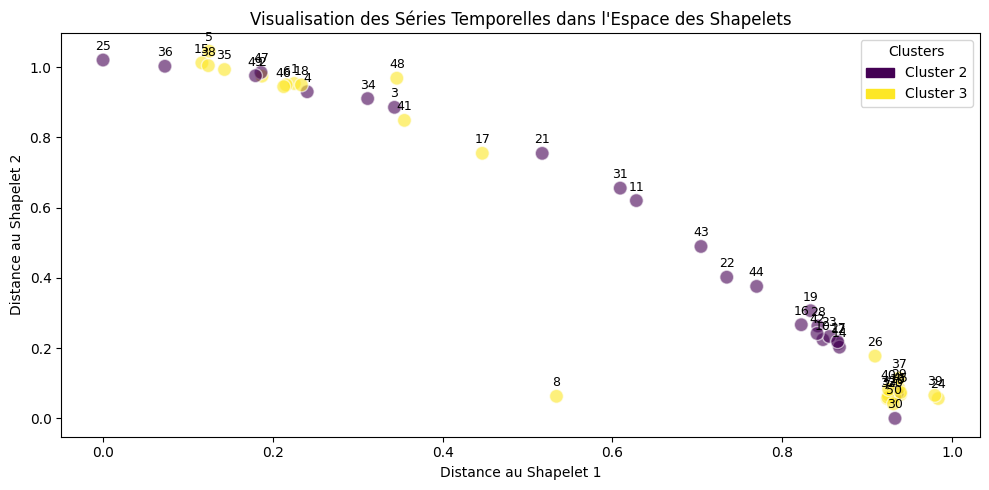

In [1320]:
# Représentation graphique des résultats

# 1. Calculer les distances entre les séries temporelles et les shapelets
# Nous allons calculer les distances entre chaque série temporelle et chaque shapelet
all_distances = []

for s in shap12:  # Pour chaque shapelet
    dis, _ = computeDistance(s, gun_point_data)  # Calculer les distances entre cette shapelet et toutes les séries temporelles
    all_distances.append(dis)

# Convertir la liste de distances en une matrice où chaque ligne est une série temporelle
# et chaque colonne est une distance à un shapelet
distance_matrix = np.array(all_distances).T  # Chaque ligne correspond à une série temporelle, chaque colonne à un shapelet

# 2. Récupérer les labels de cluster
cluster_labels = classe_gun_point  # Récupérer les labels de clusters à partir du résultat du clustering

# 3. Visualisation dans l'espace des shapelets
# Ici, on utilise les deux premières distances pour le graphique
x = distance_matrix[:, 0]  # Première dimension (distance au Shapelet 1)
y = distance_matrix[:, 1]  # Deuxième dimension (distance au Shapelet 2)

# 4. Créer le graphique avec les clusters
plt.figure(figsize=(10, 5))

# Créer un scatter plot avec les points colorés selon le cluster auquel ils appartiennent
scatter = plt.scatter(x, y, c=cluster_labels, cmap='viridis', alpha=0.6, edgecolors='w', s=100)

# Titre et axes
plt.title("Visualisation des Séries Temporelles dans l'Espace des Shapelets")
plt.xlabel("Distance au Shapelet 1")
plt.ylabel("Distance au Shapelet 2")

# Ajouter une légende pour les clusters
# Création des handles pour la légende
cluster_patches = [mpatches.Patch(color=scatter.cmap(scatter.norm(i)), label=f"Cluster {i+1}") for i in np.unique(cluster_labels)]
plt.legend(handles=cluster_patches, title="Clusters")

# Ajouter les numéros de séries temporelles au-dessus des points
for i, (xi, yi) in enumerate(zip(x, y)):
    plt.text(xi, yi + 0.02, str(i+1), ha='center', va='bottom', fontsize=9, color='black')

# Afficher le graphique
plt.tight_layout()
plt.show()


*Vrais labels*

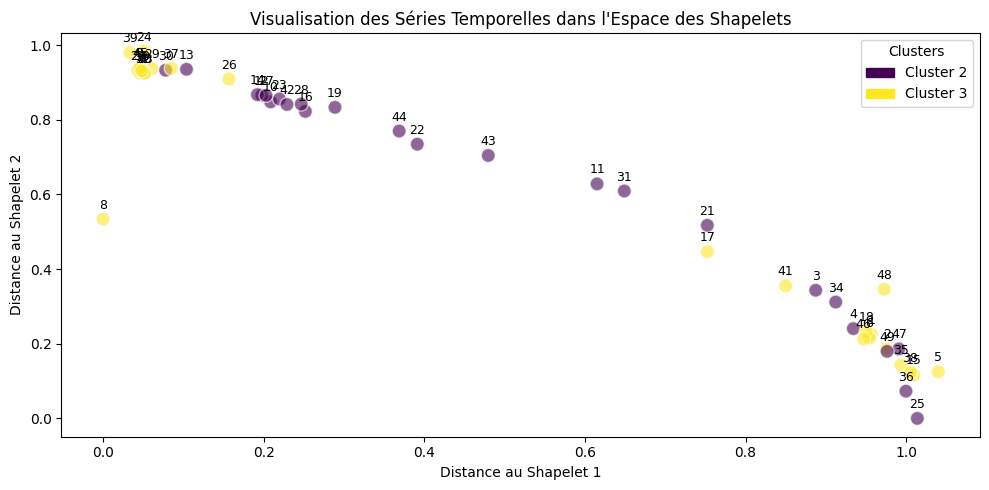

In [436]:
# Représentation graphique des résultats

import matplotlib.patches as mpatches

# 1. Calculer les distances entre les séries temporelles et les shapelets
# Nous allons calculer les distances entre chaque série temporelle et chaque shapelet
all_distances = []

for s in shap12:  # Pour chaque shapelet
    dis, _ = computeDistance(s, gun_point_data)  # Calculer les distances entre cette shapelet et toutes les séries temporelles
    all_distances.append(dis)

# Convertir la liste de distances en une matrice où chaque ligne est une série temporelle
# et chaque colonne est une distance à un shapelet
distance_matrix = np.array(all_distances).T  # Chaque ligne correspond à une série temporelle, chaque colonne à un shapelet

# 2. Récupérer les labels de cluster
cluster_labels = classe_gun_point  # Récupérer les labels de clusters à partir du résultat du clustering

# 3. Visualisation dans l'espace des shapelets
# Ici, on utilise les deux premières distances pour le graphique
x = distance_matrix[:, 0]  # Première dimension (distance au Shapelet 1)
y = distance_matrix[:, 1]  # Deuxième dimension (distance au Shapelet 2)

# 4. Créer le graphique avec les clusters
plt.figure(figsize=(10, 5))

# Créer un scatter plot avec les points colorés selon le cluster auquel ils appartiennent
scatter = plt.scatter(x, y, c=cluster_labels, cmap='viridis', alpha=0.6, edgecolors='w', s=100)

# Titre et axes
plt.title("Visualisation des Séries Temporelles dans l'Espace des Shapelets")
plt.xlabel("Distance au Shapelet 1")
plt.ylabel("Distance au Shapelet 2")

# Ajouter une légende pour les clusters
# Création des handles pour la légende
cluster_patches = [mpatches.Patch(color=scatter.cmap(scatter.norm(i)), label=f"Cluster {i+1}") for i in np.unique(cluster_labels)]
plt.legend(handles=cluster_patches, title="Clusters")

# Ajouter les numéros de séries temporelles au-dessus des points
for i, (xi, yi) in enumerate(zip(x, y)):
    plt.text(xi, yi + 0.02, str(i+1), ha='center', va='bottom', fontsize=9, color='black')

# Afficher le graphique
plt.tight_layout()
plt.show()


## 3.4 Syn-control

In [1434]:
# Importation des données 
syn_control_dataset = pd.read_csv("synthetic_control.data", header=None, delim_whitespace=True)
labels = []
class_numbers = [0, 1, 2, 3, 4, 5]  # Correspondance des classes

# Génération des labels numériques en fonction des indices
for i in range(6):
    labels.extend([class_numbers[i]] * 100)
classe_syn_control = []
class_numbers = [0, 1, 2, 3, 4, 5]  # Correspondance des classes

# Génération des labels numériques en fonction des indices
for i in range(6):
    classe_syn_control.extend([class_numbers[i]] * 100)


classe_syn_control = pd.DataFrame(classe_syn_control)

C:\Users\sorob\AppData\Local\Temp\ipykernel_29396\889272661.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  syn_control_dataset = pd.read_csv("synthetic_control.data", header=None, delim_whitespace=True)


In [1440]:
syn_control_dataset

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,28.7812,34.4632,31.3381,31.2834,28.9207,33.7596,25.3969,27.7849,35.2479,27.1159,...,31.4333,24.5556,33.74310,25.0466,34.93180,34.98790,32.4721,33.3759,25.46520,25.8717
1,24.8923,25.7410,27.5532,32.8217,27.8789,31.5926,31.4861,35.5469,27.9516,31.6595,...,32.5577,31.0205,26.64180,28.4331,33.65640,26.42440,28.4661,34.2484,32.10050,26.6910
2,31.3987,30.6316,26.3983,24.2905,27.8613,28.5491,24.9717,32.4358,25.2239,27.3068,...,33.6318,26.5966,25.53870,32.5434,25.57720,29.98970,31.3510,33.9002,29.54460,29.3430
3,25.7740,30.5262,35.4209,25.6033,27.9700,25.2702,28.1320,29.4268,31.4549,27.3200,...,34.6292,28.7261,28.29790,31.5787,34.61560,32.54920,30.9827,24.8938,27.36590,25.3069
4,27.1798,29.2498,33.6928,25.6264,24.6555,28.9446,35.7980,34.9446,24.5596,34.2366,...,27.7218,27.9601,35.71980,27.5760,35.33750,29.99930,34.2149,33.1276,31.10570,31.0179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,29.6254,25.5034,31.5978,31.4663,33.5488,28.2935,28.9244,30.6922,25.3301,26.8728,...,26.7468,18.8795,21.33210,23.6915,22.30970,19.13610,15.2851,22.5278,20.65720,24.1289
596,27.4144,25.3973,26.4600,31.9782,26.1251,27.4629,30.4888,34.9292,27.5580,30.6863,...,19.1063,11.4546,16.88800,18.2691,11.58310,14.11760,20.2289,11.1314,9.98019,10.7201
597,35.8990,26.6719,34.1911,35.8270,25.1009,24.8564,25.8141,30.6301,34.2124,32.5874,...,21.8787,16.0021,15.28790,16.9459,17.53380,16.84640,16.5460,15.9268,18.08430,17.4747
598,24.5383,24.2802,28.2814,27.1316,26.6623,32.1100,32.8100,30.4829,35.8586,25.3866,...,19.6441,11.5238,15.41850,12.6699,13.11640,8.23496,12.0419,19.3096,12.99850,17.4599


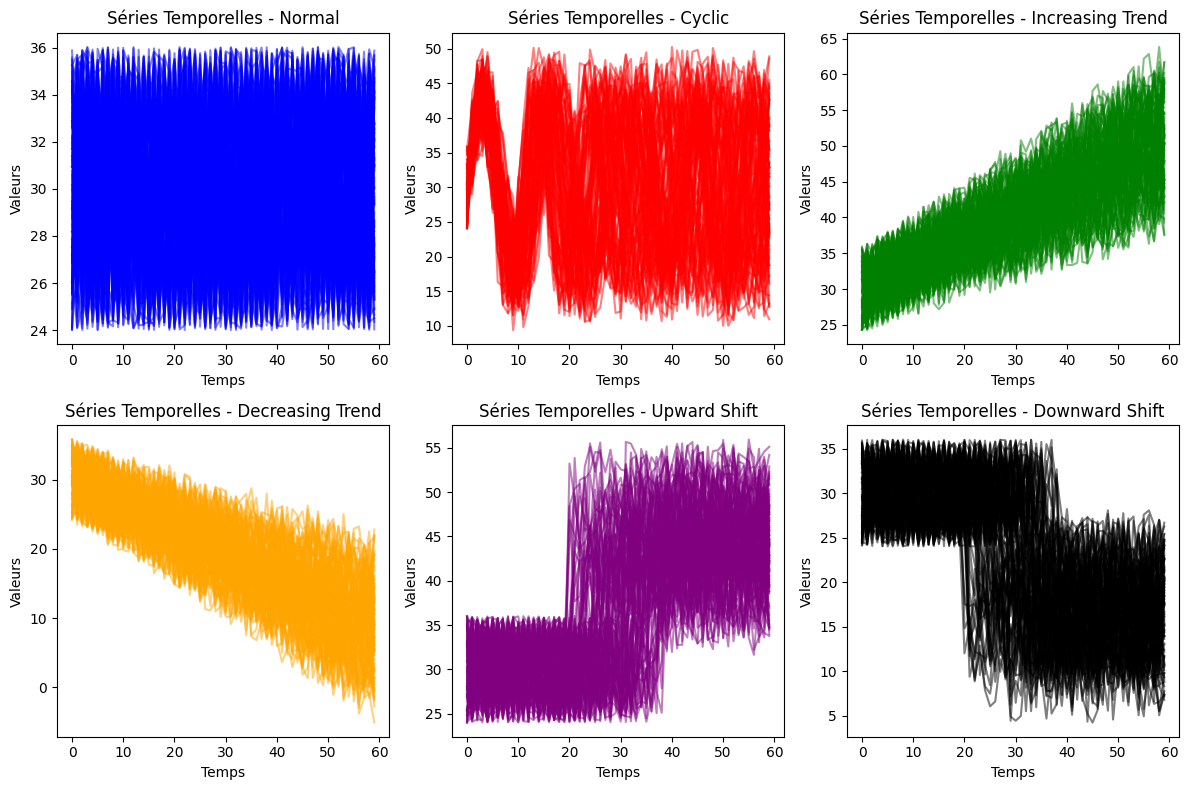

In [1441]:
import matplotlib.pyplot as plt

# Associer chaque classe aux séries temporelles correspondantes
class_0 = syn_control_dataset.iloc[0:100]   # Normal
class_1 = syn_control_dataset.iloc[100:200] # Cyclic
class_2 = syn_control_dataset.iloc[200:300] # Increasing trend
class_3 = syn_control_dataset.iloc[300:400] # Decreasing trend
class_4 = syn_control_dataset.iloc[400:500] # Upward shift
class_5 = syn_control_dataset.iloc[500:600] # Downward shift

# Créer une figure avec 2 lignes et 3 colonnes pour afficher les classes
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

# Définition des classes et couleurs
classes = [class_0, class_1, class_2, class_3, class_4, class_5]
colors = ["blue", "red", "green", "orange", "purple", "black"]
titles = ["Normal", "Cyclic", "Increasing Trend", "Decreasing Trend", "Upward Shift", "Downward Shift"]

# Boucle pour afficher les séries temporelles dans les sous-graphiques
for i, (cls, color, title) in enumerate(zip(classes, colors, titles)):
    row, col = divmod(i, 3)  # Calculer la position dans la grille (2 lignes, 3 colonnes)
    axs[row, col].plot(cls.T, color=color, alpha=0.5)  # .T pour transposer et aligner les séries
    axs[row, col].set_title(f"Séries Temporelles - {title}")
    axs[row, col].set_xlabel("Temps")
    axs[row, col].set_ylabel("Valeurs")

# Ajustement pour éviter le chevauchement
plt.tight_layout()
plt.show()


In [ ]:
# Appel de la fonction extractUShapelets sur trace_data avec une longueur des U-shapelets fixée à 33, et k = 4 

import time

# Enregistrez le temps de départ
start_time = time.time()

# Appel de la fonction extractUShapelets sur trace_data avec une longueur des U-shapelets à extraire entre 50 et 200, et k = 4 
shap_syn_control, serie_syn_control = extractUShapelets(syn_control_dataset,59,6,1)

# Enregistrez le temps de fin
end_time = time.time()

# Calcul du temps écoulé
execution_time = end_time - start_time

# Affichage du temps d'exécution
print(f"Temps d'exécution de extractUShapelets sur le dataset SynControl (avec len(shapelet) entre 1 et 59) : {execution_time:.4f} secondes")


Temps d'exécution de extractUShapelets sur le dataset SynControl (avec len(shapelet) entre 1 et 59) : 2968.0029 secondes

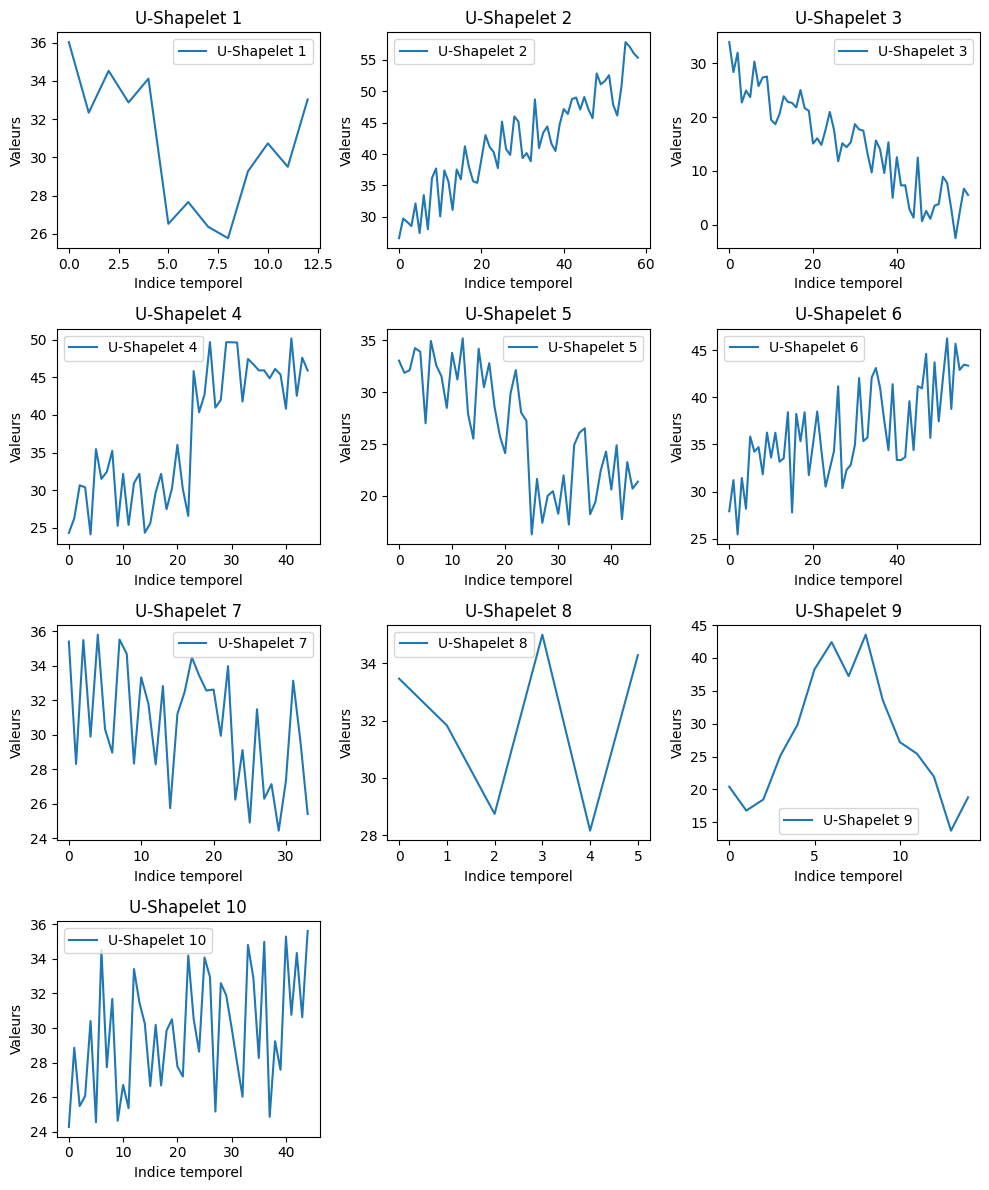

In [1464]:


# DataFrame contenant les shapelets extraits
syn_control_shapelet = pd.DataFrame(shap_syn_control)

# Déterminer le nombre de colonnes et de lignes nécessaires
n = len(shap_syn_control)
cols = 3  # Par exemple, vous pouvez ajuster ce nombre
rows = (n // cols) + (n % cols > 0)  # Calcul des lignes nécessaires pour le nombre d'éléments

# Créer une figure avec des sous-graphiques
fig, axes = plt.subplots(rows, cols, figsize=(10, 3 * rows))

# Aplatir la liste des axes pour faciliter l'accès
axes = axes.flatten()

# Tracer chaque shapelet dans un sous-graphe
for i in range(n):
    axes[i].plot(syn_control_shapelet.iloc[i], label=f'U-Shapelet {i+1}')
    axes[i].set_title(f'U-Shapelet {i+1}')
    axes[i].set_xlabel("Indice temporel")
    axes[i].set_ylabel("Valeurs")
    axes[i].legend()

# Supprimer les axes inutilisés (si n < rows * cols)
for i in range(n, len(axes)):
    fig.delaxes(axes[i])

# Ajuster l'espacement entre les graphiques
plt.tight_layout()

# Afficher la figure
plt.show()


In [1469]:
cluster_syn_control,_ = clusterData(D=syn_control_dataset, Shapelets=shap_syn_control, k=6)
print(randIndex(classe_syn_control.to_numpy(), np.array(cluster_syn_control)))

0.942632164718976
